In [1]:
# %load ./init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys

import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
import kalepy.utils
import kalepy.plot

import holodeck as holo
import holodeck.sams
import holodeck.gravwaves
from holodeck import cosmo, utils, plot, discrete, sams, relations
from holodeck.constants import MSOL, PC, YR, MPC, GYR, SPLC

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
plt.rcParams.update({'grid.alpha': 0.5})
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode

log = holo.log
log.setLevel(logging.INFO)

20:53:28 WARNING : WARNING: ``holodeck.relations`` has been deprecated!  Use ``host_relations`` and/or ``galaxy_profiles``!
This file will be removed in the near future. [relations.py:<module>]


In [32]:
def plot_bin_pop(pop):
    mt, mr = utils.mtmr_from_m1m2(pop.mass)
    redz = cosmo.a_to_z(pop.scafa)
    data = [mt/MSOL, mr, pop.sepa/PC, 1+redz]
    data = [np.log10(dd) for dd in data]
    reflect = [None, [None, 0], None, [0, None]]
    labels = [r'M/M_\odot', 'q', r'a/\mathrm{{pc}}', '1+z']
    labels = [r'${{\log_{{10}}}} \left({}\right)$'.format(ll) for ll in labels]

    if pop.eccen is not None:
        data.append(pop.eccen)
        reflect.append([0.0, 1.0])
        labels.append('e')

    kde = kale.KDE(data, reflect=reflect)
    corner = kale.Corner(kde, labels=labels, figsize=[8, 8])
    corner.plot_data(kde)
    return corner

def compare_bin_pops(dpops, labels=None, var='mass', colors=None, lws=None, 
                     density=True, hist=False, confidence=False):
    
    assert isinstance(dpops, list), '`dpops` must be a list of discrete populations'
    assert var in ['mass','mrat','sepa','redz'], "`var` must be 'mass','mrat','sepa', or 'redz'."
    if (labels is not None):
        if (len(labels) != len(dpops)) and (not isinstance(labels,str)):
            print("Warning: `labels` must be a str or a list of length len(dpops). Setting to None.")
            labels = None
    if (colors is not None):
        if (len(colors) != len(dpops)):
            print("Warning: `colors` must be a list of length len(dpops). Setting to None.")
            colors = None
    if (lws is not None):
        if (len(lws) != len(dpops)):
            print("Warning: `lws` must be a list of length len(dpops). Setting to None.")
            lws = None
   
    fig, ax = plt.subplots(figsize=[10, 5])
    ax.set(ylabel='Probability Density')
    ax.grid(alpha=0.01)
    
    if (var == 'mass') or (var == 'mrat'):
        for i,dp in enumerate(dpops):
            mt, mr = utils.mtmr_from_m1m2(dp.pop.mass)
            data = np.log10(mt/MSOL) if var=='mass' else mr
            #print(data.min(),data.max())
            xlab = r'$\log_{10}(M_{tot})$' if var=='mass' else r'$q$'
            ax.set(xlabel=xlab)
            if colors is None:
                kale.dist1d(data, density=density, hist=hist, confidence=confidence, 
                            label=dp.lbl, color=dp.color, lw=dp.lw)
            else: 
                kale.dist1d(data, density=density, hist=hist, confidence=confidence, 
                            label=labels[i], color=colors[i], lw=lws[i])

    elif var == 'sepa':
        for i,dp in enumerate(dpops):
            data = np.log10(dp.pop.sepa/PC)
            #print(data.min(),data.max())
            ax.set(xlabel=r'$\log_{10}(a) [pc]$')
            if colors is None:
                kale.dist1d(data, density=density, hist=hist, confidence=confidence, 
                            label=dp.lbl, color=dp.color, lw=dp.lw)
            else: 
                kale.dist1d(data, density=density, hist=hist, confidence=confidence, 
                            label=labels[i], color=colors[i], lw=lws[i])

    else:
        for i,dp in enumerate(dpops):
            redz = cosmo.a_to_z(dp.pop.scafa)
            data = 1+redz
            #print(data.min(),data.max())
            ax.set(xlabel=r'$\log_{10}(1+z)$')
            if colors is None:
                kale.dist1d(data, density=density, hist=hist, confidence=confidence, 
                            label=dp.lbl, color=dp.color, lw=dp.lw)
            else: 
                kale.dist1d(data, density=density, hist=hist, confidence=confidence, 
 
                            label=labels[i], color=colors[i], lw=lws[i])

def calc_bhmf(dpop, mass_type='all', mask = None, verbose = False):

    assert isinstance(dpop, Discrete), '`dpop` must be an instance of the `Discrete` class'

    data = dpop.pop.mass 
    if verbose: print(f"in calc_bhmf: {data.shape=}")

    if mask is not None:
        data = data[mask]
        if verbose: print(f"after mask, in calc_bhmf: {data.shape=}")
  
    if mass_type == 'tot':
        #mt, mr = utils.mtmr_from_m1m2(data)
        #data = mt
        data = data[:,0] + data[:,1]
        #print(f"{mt.min()=}, {mt.max()=}, {mt.mean()=}, {mt.shape=}")
        if verbose: print(f"{data.min()=}, {data.max()=}, {data.mean()=}, , {data.shape=}")
    elif mass_type == 'pri':
        #mt, mr = utils.mtmr_from_m1m2(data)
        #data = mt / (1 + mr)
        #tmp = mt / (1 + mr)
        data = data.max(axis = 1)
        #print(f"{tmp.min()=}, {tmp.max()=}, {tmp.mean()=}, {tmp.shape=}")
        if verbose: print(f"{data.min()=}, {data.max()=}, {data.mean()=}, {data.shape=}")        
    elif mass_type not in ('tot','pri','all'):
        err = "`mass_type` must be 'tot', 'pri', or 'all'"
        raise ValueError(err)

    data = np.log10(data/MSOL)
    
    if verbose: print(f"after setting mass_type, in calc_bhmf: {data.shape=}")


    mhist, mbin_edges = np.histogram(data, range=(4.25,12.25), bins=16) #bins=mbins)
    mbinsize = mbin_edges[1]-mbin_edges[0]
    mbins = mbin_edges[:-1]+mbinsize
        
    box_vol_mpc = dpop.evo._sample_volume / (1.0e6*PC)**3
    if verbose: print(f"{box_vol_mpc=}")

    return mbins, mhist / mbinsize / box_vol_mpc

def compare_bhmfs(dpops):
    
    assert isinstance(dpops, list), '`dpops` must be a list of discrete populations'

    fig, ax = plt.subplots(figsize=[10, 5])
    ax.set(ylabel='Probability Density')
    ax.grid(alpha=0.01)
    ax.set(yscale='log')
    
    for i,dp in enumerate(dpops):
        
        mbins, bhmf = calc_bhmf(dpop)
        #mt, mr = utils.mtmr_from_m1m2(dp.pop.mass)
        #data = np.log10(mt/MSOL)
        ##mbinsize = 0.5
        ##mbins = np.arange(4.75, 11.25, mbinsize)
        #mhist, mbin_edges = np.histogram(data, range=(5.25,11.25), bins=12) #bins=mbins)
        #mbinsize = mbin_edges[1]-mbin_edges[0]
        #mbins = mbin_edges[:-1]+mbinsize
        
        xlab = r'$\log_{10}(M_{tot})$' 
        ax.set(xlabel=xlab)
        ax.set(ylabel=r'BHMF [$(\log_{10} M)^{-1} Mpc^{-3}$]')
        #print(mhist.size, mbin_edges.size) #, mbins.size)
        #print(mbin_edges)
        #print(mhist)
        #box_vol_mpc = dp.evo._sample_volume / (1.0e6*PC)**3
        #print(box_vol_mpc)
        ax.plot(mbins, bhmf, color=dp.color, lw=dp.lw, label=dp.lbl)

def calc_gsmf(dpop, mass_type='all', mask = None, verbose = False):
    
    data = dpop.pop.mbulge/MSOL
    if verbose: print(f"in calc_gsmf: {data.shape=}")

    if mask is not None:
        data = data[mask]
        if verbose: print(f"after mask, in calc_gsmf: {data.shape=}")

    if mass_type == 'tot':
        data = data[:,0] + data[:,1]
    elif mass_type == 'pri':
        data = data.max(axis = 1)
    elif mass_type not in ('tot','pri','all'):
        err = "`mass_type` must be 'tot', 'pri', or 'all'"
        raise ValueError(err)

    if verbose: print(f"after setting mass_type, in calc_gsmf: {data.shape=}")

    data = np.log10(data)
    box_vol_mpc = dpop.evo._sample_volume / (1.0e6*PC)**3

    mhist, mbin_edges = np.histogram(data, range=(7.25,15.25), bins=16)
    mbinsize = mbin_edges[1]-mbin_edges[0]
    mbins = mbin_edges[:-1]+mbinsize
        
    return mbins, mhist/mbinsize/np.log(10)/box_vol_mpc

def calc_sim_gpf_and_gmr(dpop, basePath, mass_type='tot', nbins=10, mask=None, verbose=False):

    print(f"in calc_sim_gpf_and_gmr: {dpop.lbl=}, {basePath=}")
    
    data = dpop.pop.mbulge/MSOL
    #dp_box_vol_mpc = dpop.evo._sample_volume / (1.0e6*PC)**3
    dp_box_vol_mpc = dpop.pop._sample_volume / (1.0e6*PC)**3

    try:
        fpmass = dpop.pop.first_prog_mass # first progenitor mass at tmax (time of max past mass)
        npmass = dpop.pop.next_prog_mass # next progenitor mass at tmax (time of max past mass)
        prog_q_at_tmax = dpop.pop.prog_mass_ratio  # progenitor mass ratio at tmax (time of max past mass)
        mrg_dp_mstar_tot = dpop.pop.mstar_tot[:,2] # using the total tellar mass of descendant like RG15

        mrg_dp_qstar = prog_q_at_tmax
        mrg_dp_mstar = mrg_dp_mstar_tot
        print("\n\n\nDefining progenitor stellar mass ratio at tmax and descendant total mass at descendant snap as in RG15.")
        
    except:
        mrg_dp_mstar_all = dpop.pop.mbulge # this should be the total stellar mass of the descendant subhalo not the bulge mass of progs
        mrg_dp_mstar1 = np.max(mrg_dp_mstar_all, axis=1) 
        mrg_dp_mstar2 = np.min(mrg_dp_mstar_all, axis=1)
        mrg_dp_mstar_tot = mrg_dp_mstar1 + mrg_dp_mstar2
        tmp = mrg_dp_mstar1 + mrg_dp_mstar2
        #print(f"{tmp.min()=}, {tmp.max()=}, {tmp.shape=}")
        mrg_dp_qstar = mrg_dp_mstar2 / mrg_dp_mstar1
        
        #if mask is not None:
        #    data = data[mask]
        #    if verbose: print(f"after mask, in calc_gal_mrg_rate: {data.shape=}")

        ## NOTE that none of these are actually identical to the definition in RG15, 
        ## which calculates the merger rate as a function of *descendant* stellar mass
        ## and *progenitor* stellar mass ratio. `mass_type` = 'tot' will be closest, but 
        ## we might want to code up an option to use this exact defn in the future.
        if mass_type == 'tot':
            mrg_dp_mstar = mrg_dp_mstar_tot
        elif mass_type == 'pri':
            mrg_dp_mstar = mrg_dp_mstar1
        elif mass_type == 'all':
            mrg_dp_mstar = mrg_dp_mstar_all
        else:
            err = "`mass_type` must be 'tot', 'pri', or 'all'"
            raise ValueError(err)
        print("Defining progenitor stellar mass ratio at prog snap and total mass as sum of prog masses (DIFFERENT than RG15).")

     
    if verbose: print(f"{mrg_dp_qstar.min()=}, {mrg_dp_qstar.max()=}, {mrg_dp_qstar.mean()=}, {np.median(mrg_dp_qstar)=}, {mrg_dp_qstar.shape=}")
    if verbose: print(f"{mrg_dp_mstar.min()=}, {mrg_dp_mstar.max()=}, {mrg_dp_mstar.mean()=}, {np.median(mrg_dp_mstar)=}, {mrg_dp_mstar.shape=}\n\n\n")
    
    mrg_dp_redz = 1.0/dpop.pop.scafa - 1


    f = h5py.File(f"{basePath}/gsmf_all_snaps_Nmin1.hdf5","r")
    snapnums = f.attrs['SnapshotNums']
    dlgm_all_snaps = f.attrs['LogMassBinWidth']
    mbins_all_snaps = np.array(f['StellarMassBinEdges'])
    mhist_all_snaps = np.array(f['StellarMassHistograms'])
    scalefac_all_snaps = f.attrs['SnapshotScaleFacs']
    zsnaps = 1.0 / scalefac_all_snaps - 1.0
    
    #ncombine_mbins = 40
    ncombine_mbins = 10
    #ncombine_mbins = 5
    #ncombine_mbins = 2
    #ncombine_mbins = 20
    dlgm_new = dlgm_all_snaps * ncombine_mbins
    mbin_edges = mbins_all_snaps[::ncombine_mbins]
    mbin_edges = np.append(mbin_edges, mbin_edges[-1]+dlgm_new)
    mbin_edges = mbin_edges[mbin_edges >= 8.0]
    if verbose:
        print(f"{mhist_all_snaps.shape=}, {mhist_all_snaps.min()=}, {mhist_all_snaps.max()=}")
        print(f"{snapnums=}")
        print(f"{dlgm_all_snaps=}, {mbins_all_snaps.shape=}, {mhist_all_snaps.shape=}")
        #print(f"{mbins_all_snaps=}")
        print(f"{mbin_edges=}")
    
    #dq = 0.05
    #qbin_edges = np.arange(0,1+dq,dq)
    dlgq = 0.2
    #dlgq = 0.1
    #dlgq = 0.05
    #dlgq = 0.4
    #dlgq = 0.8
    #dlgq = 0.5
    #dlgq = 1.0
    #lgqbin_edges = np.arange(-4, 0+dlgq, dlgq)
    lgqbin_edges = np.arange(-3, 0+dlgq, dlgq)
    qbin_edges = 10**lgqbin_edges
    
    dz = 0.5
    #dz = 0.25
    #dz = 0.125
    #dz = 1.0
    #dz = 2.0
    #zbin_edges = np.arange(0,20+dz,dz)
    zbin_edges = np.arange(0,4+dz,dz)
    
    print("BEFORE cuts:")
    print(f"lgm min/max: {np.log10(mrg_dp_mstar.min()/MSOL)=}, {np.log10(mrg_dp_mstar.max()/MSOL)=}")
    print(f"q min/max: {mrg_dp_qstar.min()=}, {mrg_dp_qstar.max()=}")
    print(f"z min/max: {mrg_dp_redz.min()=}, {mrg_dp_redz.max()=}")

    print(f"{mbin_edges=}, {np.log10(mrg_dp_mstar.min()/MSOL)=}, {np.log10(mrg_dp_mstar.max()/MSOL)=}")
    ix_mmin = np.where(mbin_edges<np.log10(mrg_dp_mstar.min()/MSOL))[0]
    ix_mmax = np.where(mbin_edges>np.log10(mrg_dp_mstar.max()/MSOL))[0]
    print(ix_mmin, ix_mmax, mbin_edges.size)
    print(f"{qbin_edges=}, {mrg_dp_qstar.min()=}, {mrg_dp_qstar.max()=}")
    ix_qmin = np.where(qbin_edges<mrg_dp_qstar.min())[0]
    ix_qmax = np.where(qbin_edges>mrg_dp_qstar.max())[0]
    print(ix_qmin, ix_qmax, qbin_edges.size)
    print(f"{zbin_edges=}, {mrg_dp_redz.min()=}, {mrg_dp_redz.max()=}")
    ix_zmin = np.where(zbin_edges<mrg_dp_redz.min())[0]
    ix_zmax = np.where(zbin_edges>mrg_dp_redz.max())[0]
    print(ix_zmin, ix_zmax, zbin_edges.size)

    if len(ix_mmax) > 0 and ix_mmax[0] != mbin_edges.size-1:
        mbin_edges = mbin_edges[:ix_mmax[0]+1]
    if len(ix_mmin) > 0 and ix_mmin[-1] != 0:
        mbin_edges = mbin_edges[ix_mmin[-1]:]
    #qbin_edges = qbin_edges[ix_qmin[-1]:ix_qmax[0]+1]
    if len(ix_zmax) > 0 and ix_zmax[0] != zbin_edges.size-1:
        zbin_edges = zbin_edges[:ix_zmax[0]+1]
    if len(ix_zmin) > 0 and ix_zmin[-1] != 0:
        zbin_edges = zbin_edges[ix_zmin[-1]:]
    
    print("AFTER cuts:")
    print(f"lgm min/max: {np.log10(mrg_dp_mstar.min()/MSOL)=}, {np.log10(mrg_dp_mstar.max()/MSOL)=}")
    print(f"q min/max: {mrg_dp_qstar.min()=}, {mrg_dp_qstar.max()=}")
    print(f"z min/max: {mrg_dp_redz.min()=}, {mrg_dp_redz.max()=}")
    print(f"{mbin_edges=}, {np.log10(mrg_dp_mstar.min()/MSOL)=}, {np.log10(mrg_dp_mstar.max()/MSOL)=}")
    print(ix_mmin, ix_mmax, mbin_edges.size)
    print(f"{qbin_edges=}, {mrg_dp_qstar.min()=}, {mrg_dp_qstar.max()=}")
    print(ix_qmin, ix_qmax, qbin_edges.size)
    print(f"{zbin_edges=}, {mrg_dp_redz.min()=}, {mrg_dp_redz.max()=}")
    print(ix_zmin, ix_zmax, zbin_edges.size)

    mqz_hist, tmp = np.histogramdd(np.array([np.log10(mrg_dp_mstar/MSOL), mrg_dp_qstar, mrg_dp_redz]).T, 
                                   bins=(mbin_edges, qbin_edges, zbin_edges))
    #mqz_hist, (mbin_edges, qbin_edges, zbin_edges) = np.histogramdd(np.array([np.log10(mrg_dp_mstar/MSOL), 
    #                                                                          mrg_dp_qstar, 
    #                                                                          mrg_dp_redz]).T, bins=nbins)
    
    
    for i in range(mbin_edges.size-1):
        for j in range(qbin_edges.size-1):                
            for k in range(zbin_edges.size-1):
                
                if mqz_hist[i,j,k] < 10:
                    mqz_hist[i,j,k] = 0
                    #print(f"mqz_hist[{i},{j},{k}]={mqz_hist[i,j,k]} for {mbin_edges[i]}<m<{mbin_edges[i+1]},"
                    #      f"{qbin_edges[j]}<q<{qbin_edges[j+1]}, {zbin_edges[k]}<z<{zbin_edges[k+1]}")

    if verbose:
        print(f"{mqz_hist.shape=}, {mbin_edges.shape=}, {qbin_edges.shape=}, {zbin_edges.shape=}")
        print(f"{mbin_edges=}")
        print(f"{qbin_edges=}")
        print(f"{zbin_edges=}")
        print(f"{mbins_all_snaps=}")
        print(f"{mhist_all_snaps.shape=}, {mhist_all_snaps.min()=}, {mhist_all_snaps.max()=}")

    ## now load galaxy stellar masses and redshifts for each snapshot
    ## and calculate the avg number of galaxies per snapshot in each bin
    
    Ngal_per_snap = np.zeros((mbin_edges.size-1, snapnums.size))
    avg_Ngal_per_zbin = np.zeros((mbin_edges.size-1, zbin_edges.size-1))
    if verbose:
        print(f"{zsnaps=}")
        print(f"{zbin_edges=}")
        print(f"looping thru snaps for {basePath=}")
        
    for i,n in enumerate(snapnums):
        #if n%10 == 0: 
        # note that RG15 uses total subhalo mass, not MassInRad.
        #subs = il.groupcat.loadSubhalos(basePath, n, fields=['SubhaloLenType','SubhaloMassType'])
        #print("finished loading data from snap.")
        #mstar = subs['SubhaloMassType'][:,4]*1.0e10/0.704 ## GET RID OF THIS HARDCODING
        #Nstarparts = subs['SubhaloLenType'][:,4]
        #Ngal_per_snap[:, n], tmp = np.histogram(mstar[Nstarparts>10], bins=mbin_edges)
        #if verbose:
        #    print(f"processing snap {n}; {snapnums[i]=}")
            
        for j in range(mbin_edges.size-1):
            Ngal_per_snap[j,i] = mhist_all_snaps[(mbins_all_snaps[:-1]>=mbin_edges[j])&
                                                 (mbins_all_snaps[1:]<=mbin_edges[j+1]), i].sum()


    for k in range(zbin_edges.size-1):
        thisbin = Ngal_per_snap[:, (zsnaps>=zbin_edges[k])&(zsnaps<zbin_edges[k+1])]
        #if verbose:
        #    print(f"{k=}, {thisbin.shape=}, {avg_Ngal_per_zbin.shape=}")
        #    print(f"{thisbin=}")
        if thisbin.shape[1] > 0:
            avg_Ngal_per_zbin[:,k] = thisbin.sum(axis=1)/thisbin.shape[1]     # CHECK THIS! 
        else:
            if verbose: print(f"skipping empty zbin {zbin_edges[k]}-{zbin_edges[k+1]}")
            
    if verbose:
        print(f"{Ngal_per_snap.shape=}")
        print(f"{avg_Ngal_per_zbin.shape=}")
        print(f"{Ngal_per_snap=}")
        print(f"{avg_Ngal_per_zbin=}")

    
    gpf = np.zeros_like(mqz_hist)
    for i in range(qbin_edges.size-1):
        # dNmrg(M*,q*,z) / dqstar: 
        for k in range(zbin_edges.size-1):
            for l in range(mbin_edges.size-1):
                if mqz_hist[l,i,k] > 0 and avg_Ngal_per_zbin[l,k] == 0:
                    raise ValueError(f"nonzero merger hist with zero galaxy hist ({l=},{i=},{k=})")
                if avg_Ngal_per_zbin[l,k] > 0:
                    gpf[l,i,k] = mqz_hist[l,i,k] / avg_Ngal_per_zbin[l,k]
        #gpf[:,i,:] = mqz_hist[:,i,:] / avg_Ngal_per_zbin
        ## this gives us the pair fraction -- can also compare this! is it defined the same way in the sam???
    if verbose: print(f"{gpf.shape=}")
    #print(f"{gpf=}")

    
    ## then divide by time interval spanned by z bin, convert from yr to Gyr
    tlook_zbin_edges = cosmo.z_to_tlbk(zbin_edges) / GYR
    dt_zbins = tlook_zbin_edges[1:] - tlook_zbin_edges[:-1]
    if verbose:
        print(f"{zbin_edges=}")
        print(f"{tlook_zbin_edges=}")
        print(f"{dt_zbins=}")
        print(f"{dt_zbins.shape=}, {dt_zbins.min()=}, {dt_zbins.max()=}")
        print(f"{dt_zbins.all()}")
    assert dt_zbins.all() >= 0.0, "`dt_zbins` must be positive-valued!"

    gal_mrg_rate = gpf / dt_zbins

    ## divide by the width of the mass ratio bins to get merger rate per unit mass ratio
    if verbose: print(f"{gal_mrg_rate.shape=}")

    dqbins = qbin_edges[1:] - qbin_edges[:-1]
    if verbose: print(f"{dqbins=}")
    for i in range(dqbins.size):
        gal_mrg_rate[:,i,:] = gal_mrg_rate[:,i,:] / dqbins[i] 

    if verbose: print(f"{gal_mrg_rate.shape=}")

    
    return gpf, gal_mrg_rate, (mbin_edges, qbin_edges, zbin_edges)
    
def compare_gsmfs(dpops):
    
    assert isinstance(dpops, list), '`dpops` must be a list of binary populations'

    fig, ax = plt.subplots(figsize=[10, 5])
    ax.set(ylabel='Probability Density')
    ax.grid(alpha=0.01)
    ax.set(yscale='log')
    
    for i,dp in enumerate(dpops):
        ##mt, mr = utils.mtmr_from_m1m2(dp.pop.mass)
        #data = np.log10(dp.pop.mbulge/MSOL)
        ##print(data)
        ##mbinsize = 0.5
        ##mbins = np.arange(4.75, 11.25, mbinsize)
        #box_vol_mpc = dp.evo._sample_volume / (1.0e6*PC)**3

        #mhist, mbin_edges = np.histogram(data, range=(7.25,14.25), bins=20) #bins=mbins)
        #mbinsize = mbin_edges[1]-mbin_edges[0]
        #mbins = mbin_edges[:-1]+mbinsize
        
        #mhist_z0to1, mbin_edges_z0to1 = np.histogram(data[dp.pop.redz<1.0], range=(7.25,14.25), 
        #                                             bins=mbin_edges)
        #mhist_zgt4, mbin_edges_zgt4 = np.histogram(data[dp.pop.redz>4.0], range=(7.25,14.25), 
        #                                           bins=mbin_edges)
        ##print(f"{dp.lbl} m histograms:")
        ##print(mhist.shape, mhist_z0to1.shape, mhist_zgt4.shape, mbins.shape)
        ##print(mhist/mbinsize/np.log(10)/box_vol_mpc, mhist_z0to1/mbinsize/np.log(10)/box_vol_mpc, 
        ##      mhist_zgt4/mbinsize/np.log(10)/box_vol_mpc)
        ##print(mhist, mhist_z0to1, mhist_zgt4, mbins, mbinsize)
        xlab = r'$\log_{10}(M_{*})$' 
        ax.set(xlabel=xlab)
        ax.set(ylabel=r'GSMF [$(dex^{-1} Mpc^{-3}$]')
        ##print(mhist.size, mbin_edges.size) #, mbins.size)
        ##print(mbin_edges)
        ##print(mhist)
        ##plt.plot(mbins, mhist_z0to1/mbinsize/np.log(10)/box_vol_mpc, color=colors[i], 
        ##         lw=np.maximum(lws[i]-1,0.5), ls='--') #,label=labels[i]+' (merging gals,z<1)')
        ##plt.plot(mbins, mhist_zgt4/mbinsize/np.log(10)/box_vol_mpc, color=colors[i], 
        ##         lw=np.maximum(lws[i]-1,0.5), ls=':') #, label=labels[i]+' (merging gals,z>4)')

        mbins, gsmf = calc_gsmf(dp)
        plt.plot(mbins, gsmf, color=dp.color, lw=dp.lw,label=dp.lbl+' (merging gals, all z)')

    return fig, ax

    
def compare_gal_merger_dens(dpops, colors=None, lws=None, labels=None, 
                            sam_compare=None, gpf_flag=None, mcut=None, qcut=None,
                            legend=True):

    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131) 
    ax1.set_xlabel(r'$\log_{10}(m_{*1})$')
    ax1.set_ylabel(r'$\frac{d\eta_{gal-gal}}{d\log_{10}m_{*1}}$ [Mpc$^{-3}$]')

    ax2 = fig.add_subplot(132) 
    ax2.set_xlabel(r'$q_*$')
    ax2.set_ylabel(r'$d\eta_{gal-gal}$ / $dq_{*1}$ [Mpc$^{-3}$]')
    ax2.set_xscale('log')

    ax3 = fig.add_subplot(133) 
    ax3.set_xlabel('redshift')
    ax3.set_ylabel(r'$d\eta_{gal-gal}$ / $dz$ [Mpc$^{-3}$]')

    ls_arr = ['-.','-']
    lw_arr = [2,3]  
    color_arr = ['m','k']

    if sam_compare is not None:
        assert gpf_flag is not None, "gpf_flag must be defined if sam_compare is not None."
        
        if (not isinstance(sam_compare,list)) and (not isinstance(sam_compare,tuple)):
            sam_compare = [sam_compare]
        if (not isinstance(gpf_flag,list)) and (not isinstance(gpf_flag,tuple)):
            gpf_flag = [gpf_flag]
            
        for i,s in enumerate(sam_compare):

            lbl = 'gpf' if gpf_flag[i] else 'gmr'
            print(f"{i=}, {gpf_flag[i]=}, {lbl=}")
            
            mstar_pri, mstar_rat, mstar_tot, redz = s.mass_stellar() 
            #mstar = mstar_pri
            mstar = mstar_tot
            mstar_arr = mstar[:,-1,0]
            mstar_rat_arr = mstar_rat[0,:,0]
            redz_arr = redz[0,0,:]
            print(f"{mstar.shape=}, {mstar_rat.shape=}, {redz.shape=}")
            print(f"{mstar_arr.shape=}, {mstar_rat_arr.shape=}, {redz_arr.shape=}")
                
            if mcut is not None:
                ixm = np.where(mstar_arr>=mcut)[0][0]
                print(f"mass cut index ={ixm}")
                mstar_arr = mstar_arr[ixm:]
                mstar = mstar[ixm:,:,:]
                mstar_rat = mstar_rat[ixm:,:,:]
                redz = redz[ixm:,:,:]
                print(f"imposed mass cut >{mcut/MSOL:.4g} msun. "
                      f"new mass array shape: {mstar_arr.shape}")

            if qcut is not None:
                ixq = np.where(mstar_rat_arr >= qcut)[0][0]
                mstar_rat_arr = mstar_rat_arr[ixq:]
                mstar = mstar[:,ixq:,:]
                mstar_rat = mstar_rat[:,ixq:,:]
                redz = redz[:,ixq:,:]
                print(f"imposed mass ratio cut >{qcut} "
                      f"new mass ratio array shape: {mstar_rat_arr.shape}")
            
            print(f"{mstar.shape=}, {mstar_rat.shape=}, {redz.shape=}")
            print(f"{mstar_arr.shape=}, {mstar_rat_arr.shape=}, {redz_arr.shape=}")
                
            print(f"{mstar.shape=}, {mstar_rat.shape=}, {redz.shape=}")

            nd = s._ndens_gal(mstar, mstar_rat, redz) ## dnt need cuts bc passed arrays to it that already had
            
            print(f"{nd.shape=},{nd.min()=},{nd.max()=}")
            
            integ = utils.trapz(nd, np.log10(mstar_arr/MSOL), axis=0, cumsum=False) # int over primary mass with mrat=1
            print(f"integ over mstar_arr: {integ.shape}")
            sam_dngalgal_dz = utils.trapz(integ, mstar_rat_arr, axis=1, cumsum=False) # int over mstar_rat (same for all mstar_pri)
            print(f"integ over mstar_rat_arr: {sam_dngalgal_dz.shape}")
            sam_dngalgal_dz = sam_dngalgal_dz.sum(axis=0)
            print(f"sum over mstar_arr: {sam_dngalgal_dz.shape}")
            sam_dngalgal_dz = sam_dngalgal_dz.sum(axis=0)
            print(f"sum over mstar_rat_arr: {sam_dngalgal_dz.shape}")
            print(f"total sam_dngalgal (from dz): {sam_dngalgal_dz.sum()}")

            integ = utils.trapz(nd, mstar_rat_arr, axis=1, cumsum=False)
            sam_dngalgal_dmstar = utils.trapz(integ, redz_arr, axis=2, cumsum=False)
            sam_dngalgal_dmstar = sam_dngalgal_dmstar.sum(axis=1)
            sam_dngalgal_dmstar = sam_dngalgal_dmstar.sum(axis=1)
            print(f"total sam_dngalgal (from dmstar): {sam_dngalgal_dmstar.sum()}")

            integ = utils.trapz(nd, np.log10(mstar_arr/MSOL), axis=0, cumsum=False)
            sam_dngalgal_dmstar_rat = utils.trapz(integ, redz_arr, axis=2, cumsum=False)
            sam_dngalgal_dmstar_rat = sam_dngalgal_dmstar_rat.sum(axis=0)
            sam_dngalgal_dmstar_rat = sam_dngalgal_dmstar_rat.sum(axis=1)
            print(f"total sam_dngalgal (from dmstar_rat): {sam_dngalgal_dmstar_rat.sum()}")

            ax1.plot(np.log10(mstar_arr/MSOL), sam_dngalgal_dmstar,lw=lw_arr[i],
                     ls=ls_arr[i], color=color_arr[i],label=lbl)
            ax2.plot(mstar_rat_arr, sam_dngalgal_dmstar_rat,lw=lw_arr[i],
                     ls=ls_arr[i], color=color_arr[i],label=lbl)
            ax3.plot(redz_arr, sam_dngalgal_dz,lw=lw_arr[i],
                     ls=ls_arr[i], color=color_arr[i],label=lbl)

    for i,dp in enumerate(dpops):
        dp_box_vol_mpc = dp.pop._sample_volume / (1.0e6*PC)**3

        dp_mstar = dp.pop.mbulge
        dp_mstar1 = np.max(dp_mstar, axis=1)
        dp_mstar2 = np.min(dp_mstar, axis=1)
        dp_mstar_tot = dp_mstar1 + dp_mstar2
        dp_qstar = dp_mstar2 / dp_mstar1
        
        dp_redz = 1.0/dp.pop.scafa - 1
        dp_dngalgal_tot = redz.size / dp_box_vol_mpc # total galaxy merger number density in cMpc^-3
        print(f'{dp_dngalgal_tot=}')
        dp_z_hist, dp_z_bin_edges = np.histogram(dp_redz, bins=20)
        dp_z_binsize = dp_z_bin_edges[1:] - dp_z_bin_edges[:-1]
        dp_dngalgal_dz = dp_z_hist / dp_z_binsize / dp_box_vol_mpc
        
        #lgm1_hist, lgm1_bin_edges = np.histogram(np.log10(mstar1/MSOL), bins=20)
        dp_lgm1_hist, dp_lgm1_bin_edges = np.histogram(np.log10(dp_mstar_tot/MSOL), bins=20)
        dp_lgm1_binsize = dp_lgm1_bin_edges[1:] - dp_lgm1_bin_edges[:-1]
        dp_dngalgal_dlog10m1 = dp_lgm1_hist / dp_lgm1_binsize / dp_box_vol_mpc

        dp_qstar_hist, dp_qstar_bin_edges = np.histogram(dp_qstar, bins=20)
        dp_qstar_binsize = dp_qstar_bin_edges[1:] - dp_qstar_bin_edges[:-1]
        dp_dngalgal_dqstar = dp_qstar_hist / dp_qstar_binsize / dp_box_vol_mpc
        print(f'dngalgal_tot = {dp_dngalgal_tot/dp_qstar_binsize[0]/dp_lgm1_binsize[0]/dp_z_binsize[0]}')

        ax1.set_ylim(1.0e-6,0.5)
        ax1.set_yscale('log')
        ax2.set_yscale('log')
        ax3.set_yscale('log')
        ax1.plot(dp_lgm1_bin_edges[:-1], dp_dngalgal_dlog10m1, label=dp.lbl)
        ax2.plot(dp_qstar_bin_edges[:-1], dp_dngalgal_dqstar, label=dp.lbl)
        ax3.plot(dp_z_bin_edges[:-1], dp_dngalgal_dz, label=dp.lbl)

    if legend:
        ax1.legend()
        ax2.legend()
        ax3.legend()
    fig.subplots_adjust(wspace=0.5)
                        
def plot_mbh_scaling_relations(pop, fname=None, color='r', compare_pops=None, ncols=1, nrows=1,
                               xlim=None, ylim=None):
    units = r"$[\log_{10}(M/M_\odot)]$"

    if compare_pops == None:
        fig, axes = plt.subplots(figsize=[12, 6])
        pops = [pop]
    else:
        fig, axes = plt.subplots(figsize=[12,5], ncols=ncols, nrows=nrows)
        pops = [pop] + compare_pops
        if len(pops) > ncols*nrows:
            raise ValueError(f"len(pops)>ncols*nrows. ({len(pops)} > {ncols}*{nrows}).")

    i = 0
    for idx, ax in np.ndenumerate(axes):
        if i > len(pops): break

        print(f"idx: {idx}, i: {i}")
        ax.set(xlabel=f'Stellar Mass {units}', ylabel=f'BH Mass {units}')
        if xlim is not None: ax.set(xlim=xlim)
        if ylim is not None: ax.set(ylim=ylim)

        #   ====    Plot McConnell+Ma-2013 Data    ====
        handles = []
        names = []
        if fname is not None:
            hh = _draw_MM2013_data(ax, fname)
            handles.append(hh)
            names.append('McConnell+Ma')

        #   ====    Plot MBH Merger Data    ====
        hh, nn = _draw_pop_masses(ax, pops[i], color, nplot=1e6)
        handles = handles + hh
        names = names + nn
        ax.legend(handles, names)
        
        i += 1

    return fig

def _draw_MM2013_data(ax):
    data = holo.observations.load_mcconnell_ma_2013()
    data = {kk: data[kk] if kk == 'name' else np.log10(data[kk]) for kk in data.keys()}
    key = 'mbulge'
    mass = data['mass']
    yy = mass[:, 1]
    yerr = np.array([yy - mass[:, 0], mass[:, 2] - yy])
    vals = data[key]
    if np.ndim(vals) == 1:
        xx = vals
        xerr = None
    elif vals.shape[1] == 2:
        xx = vals[:, 0]
        xerr = vals[:, 1]
    elif vals.shape[1] == 3:
        xx = vals[:, 1]
        xerr = np.array([xx-vals[:, 0], vals[:, 2]-xx])
    else:
        raise ValueError()

    idx = (xx > 0.0) & (yy > 0.0)
    if xerr is not None:
        xerr = xerr[:, idx]
    ax.errorbar(xx[idx], yy[idx], xerr=xerr, yerr=yerr[:, idx], fmt='none', zorder=10)
    handle = ax.scatter(xx[idx], yy[idx], zorder=10)
    ax.set(ylabel='MBH Mass', xlabel=key)

    return handle

def _draw_pop_masses(ax, pop, color='r', nplot=3e3):
    print(pop.mbulge.shape, pop.mass.shape)
    #xx = pop.mbulge.flatten() / MSOL
    xx = pop.mbulge[:,:2].flatten() / MSOL
    yy_list = [pop.mass]
    names = ['new']
    if hasattr(pop, '_mass'):
        yy_list.append(pop._mass)
        names.append('old')

    colors = [color, '0.5']
    handles = []
    if xx.size > nplot:
        cut = np.random.choice(xx.size, int(nplot), replace=False)
        print("Plotting {:.1e}/{:.1e} data-points".format(nplot, xx.size))
    else:
        cut = slice(None)

    for ii, yy in enumerate(yy_list):
        yy = yy.flatten() / MSOL
        data = np.log10([xx[cut], yy[cut]])
        kale.plot.dist2d(
            data, ax=ax, color=colors[ii], hist=False, contour=True,
            median=True, mask_dense=True,
        )
        hh, = plt.plot([], [], color=colors[ii])
        handles.append(hh)

    return handles, names

def plot_evo(evo, freqs=None, sepa=None, ax=None, label=None, color=None, **kwargs):
    if (freqs is None) and (sepa is None):
        err = "Either `freqs` or `sepa` must be provided!"
        log.exception(err)
        raise ValueError(err)

    if freqs is not None:
        data = evo.at('fobs', freqs)
        xx = freqs * YR
        xlabel = 'GW Frequency [1/yr]'
    else:
        data = evo.at('sepa', sepa)
        xx = sepa / PC
        xlabel = 'Binary Separation [pc]'

    if ax is None:
        fig, ax = plot.figax(xlabel=xlabel)
    else:
        fig = ax.get_figure()

    def _draw_vals_conf(ax, xx, vals, color=color, label=label):
        if color is None:
            color = ax._get_lines.get_next_color()
        if label is not None:
            ax.set_ylabel(label, color=color)
            ax.tick_params(axis='y', which='both', colors=color)
        # vals = np.percentile(vals, [25, 50, 75], axis=0) / units
        vals = utils.quantiles(vals, [0.25, 0.50, 0.75], axis=0).T
        h1 = ax.fill_between(xx, vals[0], vals[-1], alpha=0.2, color=color)
        h2, = ax.plot(xx, vals[1], alpha=0.5, lw=2.0, color=color)
        return (h1, h2)

    # handles = []
    # labels = []

    name = 'Hardening Time [yr]'
    vals = np.fabs(data['sepa'] / data['dadt']) / YR
    _draw_vals_conf(ax, xx, vals, label=name)
    # handles.append(hh)
    # labels.append(name)

    # name = 'eccen'
    # tw = ax.twinx()
    # hh, nn = _draw_vals_conf(tw, freqs*YR, name, 'green')
    # if hh is not None:
    #     handles.append(hh)
    #     labels.append(nn)

    # ax.legend(handles, labels)
    return ax

In [22]:
class Discrete:
    
    def __init__(self, freqs, freqs_edges, attrs=(None,None,'k',1.0), lbl=None, fixed_sepa=None, 
                 tau=1.0*YR, nreals=500, mod_mmbulge=False, rescale_mbulge=False, allow_mbh0=False, 
                 skip_evo=False, use_mstar_tot_as_mbulge=False):

        self.attrs = attrs
        self.freqs = freqs
        self.freqs_edges = freqs_edges
        self.lbl = lbl
        self.fname = self.attrs[0]
        self.basepath = self.attrs[1]
        self.color = self.attrs[2]
        self.lw = self.attrs[3]
        self.fixed_sepa = fixed_sepa
        self.tau = tau
        self.nreals = nreals
        self.mod_mmbulge = mod_mmbulge
        self.allow_mbh0 = allow_mbh0
        self.use_mstar_tot_as_mbulge = use_mstar_tot_as_mbulge
        
        print(f"\nCreating Discrete_Pop class instance '{self.lbl}' with tau={self.tau}, fixed_sepa={self.fixed_sepa}")
        print(f" fname={self.fname}")
        self.pop = discrete.population.Pop_Illustris(fname=self.fname, fixed_sepa=self.fixed_sepa, allow_mbh0=self.allow_mbh0, 
                                                     use_mstar_tot_as_mbulge=self.use_mstar_tot_as_mbulge)
        print(f"{self.pop.sepa.min()=}, {self.pop.sepa.max()=}, {self.pop.sepa.shape=}")
        print(f"{self.pop.mstar_tot.min()=}, {self.pop.mstar_tot.max()=}, {self.pop.mstar_tot.shape=}")

        # apply modifiers if requested
        if self.mod_mmbulge == True:
            print(f"before mass mod: {self.pop.mass.min()=}, {self.pop.mass.max()=}, {self.pop.mass.shape=}")
            print(f"before mass mod: {self.pop.mbulge.min()=}, {self.pop.mbulge.max()=}, {self.pop.mbulge.shape=}")
            print(f"after mass mod: {self.pop.mbulge.min()=}, {self.pop.mbulge.max()=}, {self.pop.mbulge.shape=}")
            self.mmbulge = holo.relations.MMBulge_KH2013()
            self.mod_KH2013 = discrete.population.PM_Mass_Reset(self.mmbulge, scatter=True, 
                                                                rescale_mbulge=rescale_mbulge)
            self.pop.modify(self.mod_KH2013)
            print(f"after mass mod: {self.pop.mass.min()=}, {self.pop.mass.max()=}, {self.pop.mass.shape=}")
            print(f"after mass mod: {self.pop.mbulge.min()=}, {self.pop.mbulge.max()=}, {self.pop.mbulge.shape=}")
            #print(f"{self.pop.sepa.min()=}, {self.pop.sepa.max()=}, {self.pop.sepa.shape=}")

        if skip_evo == False:
            # create a fixed-total-time hardening mechanism
            print(f"modeling fixed-total-time hardening...")
            self.fixed = holo.hardening.Fixed_Time_2PL.from_pop(self.pop, self.tau)
            print(f"{self.pop.sepa.min()=}, {self.pop.sepa.max()=}, {self.pop.sepa.shape=}")

            # Create an evolution instance using population and hardening mechanism
            print(f"creating evolution instance and evolving it...")
            self.evo = discrete.evolution.Evolution(self.pop, self.fixed)
            print(f"{self.evo.sepa.min()=}, {self.evo.sepa.max()=}, {self.evo.sepa.shape=}")
            print(f"{self.pop.sepa.min()=}, {self.pop.sepa.max()=}, {self.pop.sepa.shape=}")
            # evolve binary population
            self.evo.evolve()
            print(f"{self.evo._sample_volume=}")

            ## create GWB
            self.gwb = holo.gravwaves.GW_Discrete(self.evo, self.freqs, nreals=self.nreals)
            self.gwb.emit()

    def get_amplitudes_at_freqs(self, select_freqs=None):
        if (select_freqs is not None):
            print("sorry this function sucks, you cannot select freqs yet. choosing 1/yr, 1/3yr, 1/10yr.")
        
        # ---- find frequency bins closest to 1/yr, 1/(3yr), 1/(10yr)
        self.idx_ayr = np.where(np.abs(self.freqs-1/YR)==np.abs(self.freqs-1/YR).min())[0]
        self.idx_a3yr = np.where(np.abs(self.freqs-1/(3*YR))==np.abs(self.freqs-1/(3*YR)).min())[0]
        self.idx_a10yr = np.where(np.abs(self.freqs-1/(10*YR))==np.abs(self.freqs-1/(10*YR)).min())[0]
        print(self.idx_ayr,self.idx_a3yr,self.idx_a10yr)

        self.ayr = self.gwb.back[self.idx_ayr,:].flatten()
        self.a3yr = self.gwb.back[self.idx_a3yr,:].flatten()
        self.a10yr = self.gwb.back[self.idx_a10yr,:].flatten()




In [15]:
def create_dpops(tau=1.0, fsa=1.0e4, mod_mmbulge=True, nreals=500, inclIll=True, inclOldIll=False, 
                 inclT50=True, inclT300=True, inclRescale=False, allow_mbh0=False, skip_evo=False,
                 use_mstar_tot_as_mbulge=False):
    
    # ---- Set the fixed binary lifetime
    print(f"Setting inspiral timescale tau = {tau} Gyr.")
    tau = tau * GYR
    
    # ---- Define the GWB frequencies
    freqs, freqs_edges = utils.pta_freqs()

    # ---- Initialize return variables
    all_dpops = []
    tng_dpops = []

    # ---- (Optionally) set the fixed initial binary separation & initialize fsa return vars
    if fsa is not None:
        print(f"Setting fixed init binary sep = {fsa} pc.")
        fsa = fsa * PC
        all_fsa_dpops = []
        tng_fsa_dpops = []
        
    # ---- Define dpop attributes: (filename, plot color, plot linewidth)
    tpath = '/orange/lblecha/IllustrisTNG/Runs/'
    ipath = '/orange/lblecha/Illustris/'
    dpop_attrs = {
        # dont use this file; it has at least one merger remnant with mbulge=0. prob need to rerun with Ngas=10
        ### ('galaxy-mergers_Illustris-1_gas-000_dm-010_star-010_bh-000.hdf5', 'darkgreen', 1.5), 
        #'TNG50-1-N100' : ('galaxy-mergers_TNG50-1_gas-100_dm-100_star-100_bh-001.hdf5', 
        #                  tpath+'TNG50-1/output/', 'darkred', 4),
        #'TNG50-1-N100-bh0' : ('galaxy-mergers_TNG50-1_gas-100_dm-100_star-100_bh-000.hdf5', 
        #                      tpath+'TNG50-1/output/', 'darkred', 3),
        #'TNG50-1' : ('galaxy-mergers_TNG50-1_gas-800_dm-800_star-800_bh-001.hdf5', 
        #             tpath+'TNG50-1/output/', 'r', 3.5),
        #'TNG50-1-bh0' : ('galaxy-mergers_TNG50-1_gas-800_dm-800_star-800_bh-000.hdf5', 
        #                 tpath+'TNG50-1/output/', 'r', 2.5),
        #'TNG50-2' : ('galaxy-mergers_TNG50-2_gas-100_dm-100_star-100_bh-001.hdf5', 
        #             tpath+'TNG50-2/output/', 'orange', 2.5),
        #'TNG50-3' : ('galaxy-mergers_TNG50-3_gas-012_dm-012_star-012_bh-001.hdf5', 
        #             tpath+'TNG50-3/output/', 'y', 1.5),
        ##'oldIll' : (None, 'brown', 2.5),
        #---'Ill-nomprog' : ('galaxy_merger_files_with_no_mprog/galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5', 
        #---                 ipath+'Illustris-1/output/', 'g', 2.5),
        'Ill-N010-bh0' : ('galaxy-mergers_Illustris-1_gas-000_dm-000_star-010_bh-000.hdf5', 
                          ipath+'Illustris-1/output/', 'darkgreen', 1.5),
        'Ill-bh0' : ('galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-000.hdf5', 
                     ipath+'Illustris-1/output/', 'g', 1.5),
        'Ill' : ('galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5', 
                 ipath+'Illustris-1/output/', 'g', 2.5),
        'TNG100-1-N010-bh0' : ('galaxy-mergers_TNG100-1_gas-000_dm-000_star-010_bh-000.hdf5', 
                               tpath+'TNG100-1/output/', 'darkblue', 2.5),
        'TNG100-1-bh0' : ('galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-000.hdf5', 
                          tpath+'TNG100-1/output/', 'b', 1.5),
        'TNG100-1' : ('galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5', 
                      tpath+'TNG100-1/output/', 'b', 2.5),
        #---'TNG100-1-nomprog' : ('galaxy_merger_files_with_no_mprog/galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5', 
        #---                      tpath+'TNG100-1/output/', 'b', 2.5),
        #---'TNG100-1-bh0-nomprog' : ('galaxy_merger_files_with_no_mprog/galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-000.hdf5', 
        #---                          tpath+'TNG100-1/output/', 'b', 1.5),
        #---'TNG100-1-N012-bh0' : ('galaxy_merger_files_with_no_mprog/galaxy-mergers_TNG100-1_gas-012_dm-012_star-012_bh-000.hdf5', 
        #---                       tpath+'TNG100-1/output/', 'darkblue', 2.5),
        #'TNG100-2' : ('galaxy-mergers_TNG100-2_gas-012_dm-012_star-012_bh-001.hdf5', 
        #              tpath+'TNG100-1/output/', 'c', 1.5),
        #'TNG300-1' : ('galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5', tpath+'TNG300-1/output/', 'm', 1.5),
        #'TNG300-1-bh0' : ('galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-000.hdf5', tpath+'TNG300-1/output/', 'm', 1.0),
        #'TNG300-1-N100' : ('galaxy-mergers_TNG300-1_gas-100_dm-100_star-100_bh-001.hdf5', tpath+'TNG300-1/output/', 'pink', 1.5),
        #'TNG300-1-N100-bh0' : ('galaxy-mergers_TNG300-1_gas-100_dm-100_star-100_bh-000.hdf5', tpath+'TNG300-1/output/', 'pink', 1)
    }
    
    # ---- Loop thru dict and create dpops
    for l in dpop_attrs.keys():
        if ('Ill' in l) and (not inclIll): 
            continue
        if (l == 'oldIll') and (not inclOldIll):
            continue
        if ('TNG50' in l) and (not inclT50): 
            continue
        if ('TNG300' in l) and (not inclT300): 
                continue

        if '-bh0' not in l:
            dp = Discrete(freqs, freqs_edges, lbl=l, tau=tau, fixed_sepa=None, nreals=nreals,
                          allow_mbh0=allow_mbh0, skip_evo=skip_evo, attrs=dpop_attrs[l],
                          use_mstar_tot_as_mbulge=use_mstar_tot_as_mbulge)

            all_dpops = all_dpops + [dp]
            if 'Ill' not in l: 
                tng_dpops = tng_dpops + [dp]
        else:
            print(f"Skipping run {l} with bh0")

        if fsa is not None:

            lbl='fsa-mm-'+l if mod_mmbulge else 'fsa-'+l
            dp_fsa = Discrete(freqs, freqs_edges, lbl='fsa-mm-'+l, tau=tau, fixed_sepa=fsa, nreals=nreals,
                              allow_mbh0=allow_mbh0, skip_evo=skip_evo, attrs=dpop_attrs[l], 
                              mod_mmbulge=mod_mmbulge, use_mstar_tot_as_mbulge=use_mstar_tot_as_mbulge)

            all_fsa_dpops = all_fsa_dpops + [dp_fsa]
            if 'Ill' not in l: 
                tng_fsa_dpops = tng_fsa_dpops + [dp_fsa]
            
            if ('TNG300' in l) and (inclT300) and (inclRescale):
                rescale_dp_fsa = Discrete(freqs, freqs_edges, lbl='rescale-fsa-mm-'+l,tau=tau, fixed_sepa=fsa, 
                                          nreals=nreals, allow_mbh0=allow_mbh0, skip_evo=skip_evo, attrs=dpop_attrs[l],
                                          mod_mmbulge=True, use_mstar_tot_as_mbulge=use_mstar_tot_as_mbulge, rescale_mbulge=True)
                tng_fsa_dpops = tng_fsa_dpops + [rescale_dp_fsa]

        print(f"{l} dpop_attrs: {dpop_attrs[l][0]} {dpop_attrs[l][1]} {dpop_attrs[l][2]} {dpop_attrs[l][3]}")

    
    if fsa is not None:

        return all_dpops, tng_dpops, all_fsa_dpops, tng_fsa_dpops

    else:
        
        return all_dpops, tng_dpops

# Create Discrete Populations

In [16]:
#tmp0,tmp1,ill_lowcuts_dpops,tmp3 = create_dpops(allow_mbh0=True, mod_mmbulge=False, skip_evo=True)

In [17]:
##all_dpops, tng_dpops, all_fsa_dpops, tng_fsa_dpops = create_dpops(inclT300=False)
all_dpops, tng_dpops, all_fsa_dpops, tng_fsa_dpops = create_dpops(allow_mbh0=True, mod_mmbulge=False, skip_evo=True)
#all_dpops, tng_dpops, all_fsa_dpops, tng_fsa_dpops = create_dpops(allow_mbh0=True, mod_mmbulge=False, skip_evo=False)
#all_dpops, tng_dpops, all_fsa_dpops, tng_fsa_dpops = create_dpops(allow_mbh0=True, mod_mmbulge=True, skip_evo=False, 
#                                                                  use_mstar_tot_as_mbulge=True, nreals=50)
#all_dpops, tng_dpops, all_fsa_dpops, tng_fsa_dpops = create_dpops(allow_mbh0=True, mod_mmbulge=True, skip_evo=False, 
#                                                                  use_mstar_tot_as_mbulge=False, nreals=500)

Setting inspiral timescale tau = 1.0 Gyr.
Setting fixed init binary sep = 10000.0 pc.
Skipping run Ill-N010-bh0 with bh0

Creating Discrete_Pop class instance 'fsa-mm-Ill-N010-bh0' with tau=3.15576e+16, fixed_sepa=3.0856775814913676e+22
 fname=galaxy-mergers_Illustris-1_gas-000_dm-000_star-010_bh-000.hdf5
fname = /home/lblecha/nanograv/holodeck/holodeck/data/galaxy-mergers_Illustris-1_gas-000_dm-000_star-010_bh-000.hdf5
gal_rads.min()=0.0, gal_rads.max()=9.904368657660333e+23
self.sepa.min()=3.0856775814913676e+22, self.sepa.max()=3.0856775814913676e+22
21:51:03 WARNING : Changing BH mass from 0 to 1e2msun for 56706 first progs and 171829 next progs.
 Both BH masses reset for 50041 mergers. [population.py:_init]
self._use_mstar_tot_as_mbulge=False
self.mbulge.min()=0.0, self.mbulge.max()=4.320811696322499e+45
self.mstar_tot.min()=0.0, self.mstar_tot.max()=6.682484738114488e+45
21:51:04 WARNING : Changing mbulge from 0 to 1e5msun for 741 first progs and 3327 next progs.
 Both BH masses 

In [28]:
for p in all_fsa_dpops: print(p.lbl)
print("\n")
for p in all_fsa_dpops[1:-1]: print(p.lbl)
print("\n")
for i in [0,2,4,5]: print(all_fsa_dpops[i].lbl)
print("\n")
all_fsa_bh0_dpops = [all_fsa_dpops[0]]+[all_fsa_dpops[1]]+[all_fsa_dpops[3]]+[all_fsa_dpops[4]]
for p in all_fsa_bh0_dpops: print(p.lbl)
print("\n")
ill_fsa_bh0_dpops = [all_fsa_dpops[0]]+[all_fsa_dpops[1]]
for p in ill_fsa_bh0_dpops: print(p.lbl)
tng_fsa_bh0_dpops = [all_fsa_dpops[3]]+[all_fsa_dpops[4]]
for p in tng_fsa_bh0_dpops: print(p.lbl)
tng_fsa_dpops = all_fsa_dpops[3:]
ill_fsa_dpops = all_fsa_dpops[:3]


fsa-mm-Ill-N010-bh0
fsa-mm-Ill-bh0
fsa-mm-Ill
fsa-mm-TNG100-1-N010-bh0
fsa-mm-TNG100-1-bh0
fsa-mm-TNG100-1


fsa-mm-Ill-bh0
fsa-mm-Ill
fsa-mm-TNG100-1-N010-bh0
fsa-mm-TNG100-1-bh0


fsa-mm-Ill-N010-bh0
fsa-mm-Ill
fsa-mm-TNG100-1-bh0
fsa-mm-TNG100-1


fsa-mm-Ill-N010-bh0
fsa-mm-Ill-bh0
fsa-mm-TNG100-1-N010-bh0
fsa-mm-TNG100-1-bh0


fsa-mm-Ill-N010-bh0
fsa-mm-Ill-bh0
fsa-mm-TNG100-1-N010-bh0
fsa-mm-TNG100-1-bh0


# Create SAMs

In [7]:
print("creating SAM using Galaxy Pair Fraction (GPF) + Galaxy Merger Timescale (GMT)...")

sam = sams.Semi_Analytic_Model(gpf = sams.GPF_Power_Law())

print("SKIPPING HARDENING")

#print("    ...calculating hardening")
#hard = holo.hardening.Fixed_Time_2PL_SAM(sam, all_fsa_dpops[0].tau, sepa_init=1.0e4*PC)
#print("    ...creating gwb")
#gwb_sam = sam.gwb_new(all_fsa_dpops[0].freqs_edges, hard, realize=500)

creating SAM using Galaxy Pair Fraction (GPF) + Galaxy Merger Timescale (GMT)...
20:53:33 INFO : Galaxy pair-fraction provided, using galaxy pair-fraction and merger-time. [sam.py:__init__]
SKIPPING HARDENING


In [8]:
print("creating 'no-GPF' SAM using Galaxy Merger Rate (GMR) "
      "    (uses galaxy merger rates directly from RG15 instead of GPF+GMT)...")

sam_no_gpf = sams.Semi_Analytic_Model()

print("SKIPPING HARDENING")

#print("    ...calculating hardening for no-GPF SAM")
#hard_no_gpf = holo.hardening.Fixed_Time_2PL_SAM(sam_no_gpf, all_fsa_dpops[0].tau, sepa_init=1.0e4*PC)
#print("    ...creating gwb for no-GPF SAM")
#gwb_sam_no_gpf = sam_no_gpf.gwb_new(all_fsa_dpops[0].freqs_edges, hard_no_gpf, realize=50)

creating 'no-GPF' SAM using Galaxy Merger Rate (GMR)     (uses galaxy merger rates directly from RG15 instead of GPF+GMT)...
20:53:33 INFO : No galaxy pair-fraction given, using galaxy merger-rate. [sam.py:__init__]
SKIPPING HARDENING


# TESTING

In [9]:

def compare_gal_merger_rate(dpops, colors=None, lws=None, labels=None, sam_compare=None,
                            gpf_flag=None, mcut=None, qcut=None, legend=True, 
                            filename='compare_gmr.png', verbose=False):

    #fig = plt.figure(figsize=(12,3))
    fig = plt.figure(figsize=(12,12))

    # gmr vs descendant mass
    mlbl = r'$\log_{10}(m_{*1})$'
    mxlims = (7.5,12.5)
    mylims = (1.0e-3,1.0e5)
    ax1 = fig.add_subplot(331) 
    ax1.set(yscale='log',xlabel=mlbl, xlim=mxlims, ylim=mylims)
    ax2 = fig.add_subplot(332) 
    ax2.set(yscale='log',xlabel=mlbl, xlim=mxlims, ylim=mylims)
    ax3 = fig.add_subplot(333) 
    ax3.set(yscale='log',xlabel=mlbl, xlim=mxlims, ylim=mylims)

    # gmr vs mass ratio
    qlbl = r'$q_*$'
    qxlims = (1.0e-4,1.0)
    qylims = (1.0e-3,1.0e5)
    ax4 = fig.add_subplot(334) 
    ax4.set(xscale='log',yscale='log',xlabel=qlbl, xlim=qxlims, ylim=qylims)
    ax5 = fig.add_subplot(335) 
    ax5.set(xscale='log',yscale='log',xlabel=qlbl,  xlim=qxlims, ylim=qylims)
    ax6 = fig.add_subplot(336) 
    ax6.set(xscale='log',yscale='log',xlabel=qlbl, xlim=qxlims, ylim=qylims)

    # gmr vs z
    zlbl = '1+z'
    zxlims = (1,9)
    zylims = (1.0e-3,1.0e5)
    ax7 = fig.add_subplot(337) 
    ax7.set(xscale='log',yscale='log',xlabel=zlbl, xlim=zxlims, ylim=zylims)
    ax8 = fig.add_subplot(338) 
    ax8.set(xscale='log',yscale='log',xlabel=zlbl, xlim=zxlims, ylim=zylims)
    ax9 = fig.add_subplot(339) 
    ax9.set(xscale='log',yscale='log',xlabel=zlbl, xlim=zxlims, ylim=zylims)



    if sam_compare is not None:
        assert gpf_flag is not None, "gpf_flag must be defined if sam_compare is not None."
        
        if (not isinstance(sam_compare,list)) and (not isinstance(sam_compare,tuple)):
            sam_compare = [sam_compare]
        if (not isinstance(gpf_flag,list)) and (not isinstance(gpf_flag,tuple)):
            gpf_flag = [gpf_flag]

        #ls_arr = ['-.','-']
        lw_arr = [2,3]  
        #color_arr = ['m','k']
        ls_arr = ['-','-']
        color_arr = ['k','k']

        #tgt_m = np.array([1.0e10,1.0e11])
        #tgt_q = np.array([1.0e-3,0.1])
        #tgt_z = np.array([0.1,1.0])
        tgt_m = np.array([1.0e9,1.0e10,1.0e11])
        tgt_q = np.array([1.0e-3,1.0e-2,0.1,0.25])
        tgt_z = np.array([0.1,1.0,2.0])

        qcolor = ['orange','darkorange','red','darkred']
        mcolor = ['cyan','green','blue']
        zcolor = ['thistle','violet','magenta']
        alpha_arr = [1.0,0.75,0.5,0.25]
        
        for i,s in enumerate(sam_compare):
    
            lbl = 'gpf' if gpf_flag[i] else 'gmr'
            if verbose: print(f"{i=}, {gpf_flag[i]=}, {lbl=}")

            mstar_pri, mstar_rat, mstar_tot, redz = s.mass_stellar() 
            #mstar = mstar_pri
            mstar = mstar_tot
            mstar_arr = mstar[:,-1,0]
            mstar_rat_arr = mstar_rat[0,:,0]
            redz_arr = redz[0,0,:]
            
            target_m_bin = np.zeros_like(tgt_m)
            target_m_ix = np.zeros_like(tgt_m).astype('int64')
            for n in range(len(tgt_m)):
                ix = np.where(np.abs(mstar_arr/MSOL-tgt_m[n])==
                              np.min(np.abs(mstar_arr/MSOL-tgt_m[n])))[0][0]
                target_m_bin[n] = mstar_arr[ix]
                target_m_ix[n] = ix
                #print((f"{ix=}, {mstar_arr[ix]=}, {target_m_bin[n]=}, "
                #       f"{mstar_arr[ix+1]=}, {mstar_arr[ix-1]=}"))

            target_q_bin = np.zeros_like(tgt_q)
            target_q_ix = np.zeros_like(tgt_q).astype('int64')
            for n in range(len(tgt_q)):
                ix = np.where(np.abs(mstar_rat_arr-tgt_q[n])==
                              np.min(np.abs(mstar_rat_arr-tgt_q[n])))[0][0]
                target_q_bin[n] = mstar_rat_arr[ix]
                target_q_ix[n] = ix
                #print((f"{ix=}, {mstar_rat_arr[ix]=}, {target_q_bin[n]=}, "
                #       f"{mstar_rat_arr[ix+1]=}, {mstar_rat_arr[ix-1]=}"))
    
            target_z_bin = np.zeros_like(tgt_z)
            target_z_ix = np.zeros_like(tgt_z).astype('int64')
            for n in range(len(tgt_z)):
                ix = np.where(np.abs(redz_arr-tgt_z[n])==
                              np.min(np.abs(redz_arr-tgt_z[n])))[0][0]
                target_z_bin[n] = redz_arr[ix]
                target_z_ix[n] = ix
                #print((f"{ix=}, {redz_arr[ix]=}, {target_redz_bin[n]=}, "
                #       f"{redz_arr[ix+1]=}, {redz_arr[ix-1]=}"))
                
            if verbose:
                print(f"{tgt_m=}, {target_m_bin/MSOL=}, {target_m_ix=} ")
                print(f"{tgt_q=}, {target_q_bin=}, {target_q_ix=} ")                
                print(f"{tgt_z=}, {target_z_bin=}, {target_z_ix=} ")

            if mcut is not None:
                ix = np.where(mstar_arr>=mcut)[0][0]
                mstar_arr = mstar_arr[ix:]
                mstar = mstar[ix:,:,:]
                mstar_rat = mstar_rat[ix:,:,:]
                redz = redz[ix:,:,:]
                print(f"imposed mass cut >{mcut/MSOL} msun. "
                      f"new mass array shape: {mstar_arr.shape}")
            if qcut is not None:
                ixq = np.where(mstar_rat_arr >= qcut)[0][0]
                mstar_rat_arr = mstar_rat_arr[ixq:]
                mstar = mstar[:,ixq:,:]
                mstar_rat = mstar_rat[:,ixq:,:]
                redz = redz[:,ixq:,:]
                print(f"imposed mass ratio cut >{qcut/MSOL} msun. "
                      f"new mass ratio array shape: {mstar_rat_arr.shape}")
            
            gal_merger_rate = s._gal_merger_rate(mstar, mstar_rat, redz) * GYR # convert from s^-1 to Gyr^-1   
                
            if verbose: 
                print(f"\n\n{mstar.shape=},{mstar_rat.shape=},{redz.shape=}")
                print(f'{s._gal_merger_rate(mstar, mstar_rat, redz).shape=}')
                print(gal_merger_rate.min(),gal_merger_rate.max())
        
            #print("calculating sam merger rate vs z:")
            #integ = utils.trapz(gal_merger_rate, np.log10(mstar_arr/MSOL), axis=0, cumsum=False) # int over primary mass with mrat=1
            #print(f"integ over mstar_arr: {integ.shape}")
            #sam_gal_mrg_rate_vs_z = utils.trapz(integ, mstar_rat_arr, axis=1, cumsum=False) # int over mstar_rat (same for all mstar_pri)
            #print(f"integ over mstar_rat_arr: {sam_gal_mrg_rate_vs_z.shape}")
            #sam_gal_mrg_rate_vs_z = sam_gal_mrg_rate_vs_z.sum(axis=0)
            #print(f"sum over mstar_arr: {sam_gal_mrg_rate_vs_z.shape}")
            #sam_gal_mrg_rate_vs_z = sam_gal_mrg_rate_vs_z.sum(axis=0)
            #print(f"sum over mstar_rat_arr: {sam_gal_mrg_rate_vs_z.shape}")
            ##print(f"total sam_gal_mrg_rate_vs_z={sam_gal_mrg_rate_vs_z}")
                
            
            #integ = utils.trapz(gal_merger_rate, mstar_rat_arr, axis=1, cumsum=False)
            #sam_gal_mrg_rate_vs_m = utils.trapz(integ, redz_arr, axis=2, cumsum=False)
            #sam_gal_mrg_rate_vs_m = sam_gal_mrg_rate_vs_m.sum(axis=1)
            #sam_gal_mrg_rate_vs_m = sam_gal_mrg_rate_vs_m.sum(axis=1)
            ##print(f"sam_gal_mrg_rate_vs_m={sam_gal_mrg_rate_vs_m}")

            sam_gmr_tgtq_tgtz_vs_m = np.zeros((mstar_arr.size,target_q_bin.size,target_z_bin.size))
            sam_gmr_tgtm_tgtz_vs_q = np.zeros((target_m_bin.size,mstar_rat_arr.size,target_z_bin.size))
            sam_gmr_tgtm_tgtq_vs_z = np.zeros((target_m_bin.size,target_q_bin.size,redz_arr.size))
            
            for n in range(target_z_bin.size):
                for j in range(target_q_bin.size):
                    sam_gmr_tgtq_tgtz_vs_m[:,j,n] = gal_merger_rate[:,target_q_ix[j],target_z_ix[n]]
                    if verbose:
                        print(f"calculating sam gmr vs m for q={target_q_bin[j]},z={target_z_bin[n]}")
                        print(f"{target_q_ix[j]=},{target_z_ix[n]=}")
                        print((f"{sam_gmr_tgtq_tgtz_vs_m[:,j,n].shape}, {sam_gmr_tgtq_tgtz_vs_m[:,j,n].max()}, "
                              f"{sam_gmr_tgtq_tgtz_vs_m[:,j,n].min()} "))

                for k in range(target_m_bin.size):
                    sam_gmr_tgtm_tgtz_vs_q[k,:,n] = gal_merger_rate[target_m_ix[k],:,target_z_ix[n]]
                    if verbose:
                        print(f"calculating sam gmr vs q for m={target_m_bin[k]},z={target_z_bin[n]}")
                        print(f"{target_m_ix[k]=},{target_z_ix[n]=}")
                        print((f"{sam_gmr_tgtm_tgtz_vs_q[k,:,n].shape}, {sam_gmr_tgtq_tgtz_vs_m[k,:,n].max()}, "
                              f"{sam_gmr_tgtm_tgtz_vs_q[k,:,n].min()} "))

                        
            for j in range(target_q_bin.size):
                for k in range(target_m_bin.size):
                    sam_gmr_tgtm_tgtq_vs_z[k,j,:] = gal_merger_rate[target_m_ix[k],target_q_ix[j],:]
                    if verbose:
                        print(f"calculating sam gmr vs z for m={target_m_bin[k]},q={target_q_bin[j]}")
                        print(f"{target_m_ix[k]=},{target_q_ix[j]=}")
                        print((f"{sam_gmr_tgtm_tgtq_vs_z[k,j,:].shape}, {sam_gmr_tgtm_tgtq_vs_z[k,j,:].max()}, "
                              f"{sam_gmr_tgtm_tgtq_vs_z[k,j,:].min()} "))


                    
            for j in range(target_q_bin.size):
                lbl3 = 'SAM' if (i == 0 and j == target_q_bin.size-2) else None
                
                ax1.plot(np.log10(mstar_arr/MSOL), sam_gmr_tgtq_tgtz_vs_m[:,j,0],
                         ls=ls_arr[i],lw=0.5*j+0.5,color=color_arr[i]) #,label=lbl)    
                ax2.plot(np.log10(mstar_arr/MSOL), sam_gmr_tgtq_tgtz_vs_m[:,j,1],
                         ls=ls_arr[i],lw=0.5*j+0.5,color=color_arr[i]) #,label=lbl)
                ax3.plot(np.log10(mstar_arr/MSOL), sam_gmr_tgtq_tgtz_vs_m[:,j,2],
                         ls=ls_arr[i],lw=0.5*j+0.5,color=color_arr[i] ,label=lbl3)

                ax7.plot(redz_arr, sam_gmr_tgtm_tgtq_vs_z[0,j,:],
                         ls=ls_arr[i],lw=0.5*j+0.5,color=color_arr[i]) #,label=lbl)    
                ax8.plot(redz_arr, sam_gmr_tgtm_tgtq_vs_z[1,j,:],
                         ls=ls_arr[i],lw=0.5*j+0.5,color=color_arr[i]) #,label=lbl)    
                ax9.plot(redz_arr, sam_gmr_tgtm_tgtq_vs_z[2,j,:],
                         ls=ls_arr[i],lw=0.5*j+0.5,color=color_arr[i], label=lbl3)    
                
            for k in range(target_m_bin.size):
                ax4.plot(mstar_rat_arr, sam_gmr_tgtm_tgtz_vs_q[k,:,0],
                         ls=ls_arr[i],lw=0.5*k+0.5,color=color_arr[i]) #,label=lbl)    
                ax5.plot(mstar_rat_arr, sam_gmr_tgtm_tgtz_vs_q[k,:,1],
                         ls=ls_arr[i],lw=0.5*k+0.5,color=color_arr[i]) #,label=lbl)
                ax6.plot(mstar_rat_arr, sam_gmr_tgtm_tgtz_vs_q[k,:,2],
                         ls=ls_arr[i],lw=0.5*k+0.5,color=color_arr[i], label=lbl3)
            
            
            #integ = utils.trapz(gal_merger_rate, np.log10(mstar_arr/MSOL), axis=0, cumsum=False)
            #sam_gal_mrg_rate_vs_q = utils.trapz(integ, redz_arr, axis=2, cumsum=False)
            #sam_gal_mrg_rate_vs_q = sam_gal_mrg_rate_vs_q.sum(axis=0)
            #sam_gal_mrg_rate_vs_q = sam_gal_mrg_rate_vs_q.sum(axis=1)
            ##print(f"sam_gal_mrg_rate_vs_q={sam_gal_mrg_rate_vs_q}")

            ##ax2.plot(np.log10(mstar_pri_arr/MSOL), sam_gal_mrg_rate_vs_m, ls=ls_arr[i],lw=lw_arr[i],
            #ax1.plot(np.log10(mstar_arr/MSOL), sam_gal_mrg_rate_vs_m, ls=ls_arr[i],lw=lw_arr[i],
            #         color=color_arr[i],label=lbl)
            #ax2.plot(mstar_rat_arr, sam_gal_mrg_rate_vs_q, ls=ls_arr[i],lw=lw_arr[i],
            #         color=color_arr[i],label=lbl)
            #ax3.plot(1+redz_arr, sam_gal_mrg_rate_vs_z, ls=ls_arr[i],lw=lw_arr[i],
            #         color=color_arr[i],label=lbl)

    ls_arr = ['-','--','-.',':']
    ls_arr = ls_arr + ls_arr
    for i,dp in enumerate(dpops):
        
        sim_gpf, sim_gmr, (sim_mbin_edges, sim_qbin_edges, sim_zbin_edges) = calc_sim_gpf_and_gmr(dp, dp.basepath,verbose=verbose)

        sim_mbin_edges = 10.0**sim_mbin_edges * MSOL

        
        sim_mbin_centers = sim_mbin_edges[:-1] + 0.5 * (sim_mbin_edges[1:]-sim_mbin_edges[:-1])
        sim_qbin_centers = sim_qbin_edges[:-1] + 0.5 * (sim_qbin_edges[1:]-sim_qbin_edges[:-1])
        sim_zbin_centers = sim_zbin_edges[:-1] + 0.5 * (sim_zbin_edges[1:]-sim_zbin_edges[:-1])

        if verbose:
            print(f"\n\nLOOPING OVER DP. {dp.basepath=}\n\n")
            print(f"{dp.lbl=}, {sim_gpf.shape=}, {sim_gmr.shape=}, "
                  f"{sim_mbin_edges.shape=}, {sim_zbin_edges.shape=}, {sim_zbin_edges.shape=}")
        
            print(f"{sim_mbin_edges=}")
            print(f"{sim_mbin_centers=}")

        #dp_box_vol_mpc = dp.evo._sample_volume / (1.0e6*PC)**3
        dp_box_vol_mpc = dp.pop._sample_volume / (1.0e6*PC)**3

        
        sim_target_m_bin = np.zeros_like(tgt_m)
        sim_target_m_ix = np.zeros_like(tgt_m).astype('int64')
        for n in range(len(tgt_m)):
            ix = np.where(np.abs(sim_mbin_centers/MSOL-tgt_m[n])==
                          np.min(np.abs(sim_mbin_centers/MSOL-tgt_m[n])))[0][0]
            sim_target_m_bin[n] = sim_mbin_centers[ix]
            sim_target_m_ix[n] = ix

        sim_target_q_bin = np.zeros_like(tgt_q)
        sim_target_q_ix = np.zeros_like(tgt_q).astype('int64')
        for n in range(len(tgt_q)):
            ix = np.where(np.abs(sim_qbin_centers-tgt_q[n])==
                          np.min(np.abs(sim_qbin_centers-tgt_q[n])))[0][0]
            sim_target_q_bin[n] = sim_qbin_centers[ix]
            sim_target_q_ix[n] = ix
    
        sim_target_z_bin = np.zeros_like(tgt_z)
        sim_target_z_ix = np.zeros_like(tgt_z).astype('int64')
        for n in range(len(tgt_z)):
            ix = np.where(np.abs(sim_zbin_centers-tgt_z[n])==
                          np.min(np.abs(sim_zbin_centers-tgt_z[n])))[0][0]
            sim_target_z_bin[n] = sim_zbin_centers[ix]
            sim_target_z_ix[n] = ix

        if verbose:
            print(f"{tgt_m=}, {sim_target_m_bin/MSOL=}, {sim_target_m_ix=} ")
            print(f"{tgt_q=}, {sim_target_q_bin=}, {sim_target_q_ix=} ")                
            print(f"{tgt_z=}, {sim_target_z_bin=}, {sim_target_z_ix=} ")

        
        #print(f"{sim_gmr=}")

        
        #print("calculating sim merger rate vs z:")
        #integ = utils.trapz(sim_gmr, sim_mbin_edges[:-1], axis=0, cumsum=False) # int over primary mass with mrat=1
        ##print(f"integ over sim mbins: {integ.shape=}, {integ}")
        #dp_gal_mrg_rate_vs_z = utils.trapz(integ, sim_qbin_edges[:-1], axis=1, cumsum=False) # int over mstar_rat (same for all mstar_pri)
        #print(f"integ over sim qbins: {dp_gal_mrg_rate_vs_z.shape}")
        #dp_gal_mrg_rate_vs_z = dp_gal_mrg_rate_vs_z.sum(axis=0)
        #print(f"sum over sim mbins: {dp_gal_mrg_rate_vs_z.shape}")
        #dp_gal_mrg_rate_vs_z = dp_gal_mrg_rate_vs_z.sum(axis=0)
        #print(f"sum over sim qbins: {dp_gal_mrg_rate_vs_z.shape}")
        #print(f"total dp_gal_mrg_rate_vs_z={dp_gal_mrg_rate_vs_z}")
        #print(f"{sim_mbin_edges=}, {sim_qbin_edges=}, {sim_zbin_edges=}")
      
        #print("calculating sim merger rate vs m:")
        #integ = utils.trapz(sim_gmr, sim_qbin_edges[:-1], axis=1, cumsum=False) # int over mrat=1
        ##print(f"integ over sim qbins: {integ.shape=}, {integ}")
        #dp_gal_mrg_rate_vs_m = utils.trapz(integ, sim_zbin_edges[:-1], axis=2, cumsum=False) # int over z
        #print(f"integ over sim zbins: {dp_gal_mrg_rate_vs_m.shape}")
        #dp_gal_mrg_rate_vs_m = dp_gal_mrg_rate_vs_m.sum(axis=1)
        #print(f"sum over sim qbins: {dp_gal_mrg_rate_vs_m.shape}")
        #dp_gal_mrg_rate_vs_m = dp_gal_mrg_rate_vs_m.sum(axis=1)
        #print(f"sum over sim zbins: {dp_gal_mrg_rate_vs_m.shape}")
        #print(f"total dp_gal_mrg_rate_vs_m={dp_gal_mrg_rate_vs_m}")
        ##print(f"{sim_mbin_edges=}, {sim_qbin_edges=}, {sim_zbin_edges=}")

        #print("calculating sim merger rate vs q:")
        #integ = utils.trapz(sim_gmr, sim_mbin_edges[:-1], axis=0, cumsum=False) # int over m
        ##print(f"integ over sim mbins: {integ.shape=}, {integ}")
        #dp_gal_mrg_rate_vs_q = utils.trapz(integ, sim_zbin_edges[:-1], axis=2, cumsum=False) # int over z
        #print(f"integ over sim zbins: {dp_gal_mrg_rate_vs_q.shape}")
        #dp_gal_mrg_rate_vs_q = dp_gal_mrg_rate_vs_q.sum(axis=0)
        #print(f"sum over sim mbins: {dp_gal_mrg_rate_vs_q.shape}")
        #dp_gal_mrg_rate_vs_q = dp_gal_mrg_rate_vs_q.sum(axis=1)
        #print(f"sum over sim zbins: {dp_gal_mrg_rate_vs_q.shape}")
        #print(f"total dp_gal_mrg_rate_vs_q={dp_gal_mrg_rate_vs_q}")
        ##print(f"{sim_mbin_edges=}, {sim_qbin_edges=}, {sim_zbin_edges=}")

        sim_gmr_tgtq_tgtz_vs_m = np.zeros((sim_mbin_centers.size,sim_target_q_bin.size,sim_target_z_bin.size))
        sim_gmr_tgtm_tgtz_vs_q = np.zeros((sim_target_m_bin.size,sim_qbin_centers.size,sim_target_z_bin.size))
        sim_gmr_tgtm_tgtq_vs_z = np.zeros((sim_target_m_bin.size,sim_target_q_bin.size,sim_zbin_centers.size))
            
        for n in range(sim_target_z_bin.size):
            for j in range(sim_target_q_bin.size):
                sim_gmr_tgtq_tgtz_vs_m[:,j,n] = sim_gmr[:,sim_target_q_ix[j],sim_target_z_ix[n]]
                if verbose:
                    print(f"calculating sim gmr vs m for q={sim_target_q_bin[j]},z={sim_target_z_bin[n]}")
                    print(f"{sim_target_q_ix[j]=},{sim_target_z_ix[n]=}")
                    print((f"{sim_gmr_tgtq_tgtz_vs_m[:,j,n].shape}, {sim_gmr_tgtq_tgtz_vs_m[:,j,n].max()}, "
                            f"{sim_gmr_tgtq_tgtz_vs_m[:,j,n].min()} "))

            for k in range(sim_target_m_bin.size):
                sim_gmr_tgtm_tgtz_vs_q[k,:,n] = sim_gmr[sim_target_m_ix[k],:,sim_target_z_ix[n]]
                if verbose:
                    print(f"calculating sim gmr vs q for m={sim_target_m_bin[k]},z={sim_target_z_bin[n]}")
                    print(f"{sim_target_m_ix[k]=},{sim_target_z_ix[n]=}")
                    print((f"{sim_gmr_tgtm_tgtz_vs_q[k,:,n].shape}, {sim_gmr_tgtq_tgtz_vs_m[k,:,n].max()}, "
                          f"{sim_gmr_tgtm_tgtz_vs_q[k,:,n].min()} "))

        for j in range(sim_target_q_bin.size):
            for k in range(sim_target_m_bin.size):
                sim_gmr_tgtm_tgtq_vs_z[k,j,:] = sim_gmr[sim_target_m_ix[k],sim_target_q_ix[j],:]
                if verbose:
                    print(f"calculating sim gmr vs z for m={sim_target_m_bin[k]},q={sim_target_q_bin[j]}")
                    print(f"{sim_target_m_ix[k]=},{sim_target_q_ix[j]=}")
                    print((f"{sim_gmr_tgtm_tgtq_vs_z[k,j,:].shape}, {sim_gmr_tgtm_tgtq_vs_z[k,j,:].max()}, "
                          f"{sim_gmr_tgtm_tgtq_vs_z[k,j,:].min()} "))

        for j in range(sim_target_q_bin.size):
            lbl1 = f"q{tgt_q[j]}" if i == 0 else None
            lbl2 = dp.lbl  if j == sim_target_q_bin.size-2 else None
            lbl3 = 'Sim' if (i == 0 and j == sim_target_q_bin.size-2) else None
            
            ax1.plot(np.log10(sim_mbin_centers/MSOL), sim_gmr_tgtq_tgtz_vs_m[:,j,0],
                     color=qcolor[j],lw=0.5*j+0.5, ls=ls_arr[i], alpha=alpha_arr[i], label=lbl1)
            ax2.plot(np.log10(sim_mbin_centers/MSOL), sim_gmr_tgtq_tgtz_vs_m[:,j,1],
                     color=qcolor[j],lw=0.5*j+0.5, ls=ls_arr[i],  alpha=alpha_arr[i],label=lbl2)
            ax3.plot(np.log10(sim_mbin_centers/MSOL), sim_gmr_tgtq_tgtz_vs_m[:,j,2],
                     color=qcolor[j],lw=0.5*j+0.5, ls=ls_arr[i],  alpha=alpha_arr[i],label=lbl3) 

            ax7.plot(sim_zbin_centers, sim_gmr_tgtm_tgtq_vs_z[0,j,:],
                     color=qcolor[j],lw=0.5*j+0.5, ls=ls_arr[i],  alpha=alpha_arr[i],label=lbl1)
            ax8.plot(sim_zbin_centers, sim_gmr_tgtm_tgtq_vs_z[1,j,:],
                     color=qcolor[j],lw=0.5*j+0.5, ls=ls_arr[i],  alpha=alpha_arr[i],label=lbl2) 
            ax9.plot(sim_zbin_centers, sim_gmr_tgtm_tgtq_vs_z[2,j,:],
                     color=qcolor[j],lw=0.5*j+0.5, ls=ls_arr[i],  alpha=alpha_arr[i],label=lbl3) 

            
        for k in range(sim_target_m_bin.size):
            lbl4 = f"m{np.log10(tgt_m[k])}" if i == 0 else None

            ax4.plot(sim_qbin_centers, sim_gmr_tgtm_tgtz_vs_q[k,:,0],
                     color=mcolor[k],lw=0.5*k+0.5, ls=ls_arr[i],  alpha=alpha_arr[i],label=lbl4)    
            ax5.plot(sim_qbin_centers, sim_gmr_tgtm_tgtz_vs_q[k,:,1],
                     color=mcolor[k],lw=0.5*k+0.5, ls=ls_arr[i],  alpha=alpha_arr[i],label=lbl2)
            ax6.plot(sim_qbin_centers, sim_gmr_tgtm_tgtz_vs_q[k,:,2],
                     color=mcolor[k],lw=0.5*k+0.5, ls=ls_arr[i],  alpha=alpha_arr[i],label=lbl3)


        
        
    #    dp_mstar = dp.pop.mbulge
    #    dp_mstar1 = np.max(dp_mstar,axis=1)
    #    dp_mstar2 = np.min(dp_mstar,axis=1)
    #    dp_mstar_tot = dp_mstar1 + dp_mstar2
    #    dp_qstar = dp_mstar2 / dp_mstar1
        
    #    dp_redz = 1.0/dp.pop.scafa - 1
    #    dp_dngalgal_tot = dp_redz.size / dp_box_vol_mpc # total galaxy merger number density in cMpc^-3
    #    print(f'{dp_dngalgal_tot=}')
    #    dp_z_hist,dp_z_bin_edges = np.histogram(dp_redz, bins=20)
    #    dp_z_binsize = dp_z_bin_edges[1:] - dp_z_bin_edges[:-1]
    #    dp_dngalgal_dz = dp_z_hist / dp_z_binsize / dp_box_vol_mpc
        
    #    #lgm1_hist, lgm1_bin_edges = np.histogram(np.log10(mstar1/MSOL), bins=20)
    #    dp_lgm1_hist, dp_lgm1_bin_edges = np.histogram(np.log10(dp_mstar_tot/MSOL), bins=20)
    #    dp_lgm1_binsize = dp_lgm1_bin_edges[1:] - dp_lgm1_bin_edges[:-1]
    #    dp_dngalgal_dlog10m1 = dp_lgm1_hist / dp_lgm1_binsize / dp_box_vol_mpc

    #    dp_qstar_hist, dp_qstar_bin_edges = np.histogram(dp_qstar, bins=20)
    #    dp_qstar_binsize = dp_qstar_bin_edges[1:] - dp_qstar_bin_edges[:-1]
    #    dp_dngalgal_dqstar = dp_qstar_hist / dp_qstar_binsize / dp_box_vol_mpc
    #    print(f'dngalgal_tot = {dp_dngalgal_tot/dp_qstar_binsize[0]/dp_lgm1_binsize[0]/dp_z_binsize[0]}')

    #    ax1.set_yscale('log')
    #    ax2.set_yscale('log')
    #    ax3.set_yscale('log')
        #ax1.plot(sim_mbin_centers, dp_gal_mrg_rate_vs_m, label=dp.lbl)
        #ax2.plot(sim_qbin_centers, dp_gal_mrg_rate_vs_q, label=dp.lbl)
        #ax3.plot(sim_zbin_centers, dp_gal_mrg_rate_vs_z, label=dp.lbl)
        #ax4.plot([0,0],[0,0], label=dp.lbl)

    #    ax2.plot(dp_qstar_bin_edges[:-1], dp_dngalgal_dqstar, label=dp.lbl)
    #    ax3.plot(dp_z_bin_edges[:-1], dp_dngalgal_dz, label=dp.lbl)

    ax1.title.set_text(f'z~{tgt_z[0]}')
    ax2.title.set_text(f'z~{tgt_z[1]}')
    ax3.title.set_text(f'z~{tgt_z[2]}')
    ax4.title.set_text(f'z~{tgt_z[0]}')
    ax5.title.set_text(f'z~{tgt_z[1]}')
    ax6.title.set_text(f'z~{tgt_z[2]}')
    ax7.title.set_text(f'm~{np.log10(tgt_m[0])}')
    ax8.title.set_text(f'm~{np.log10(tgt_m[1])}')
    ax9.title.set_text(f'm~{np.log10(tgt_m[2])}')

    fsz = 9
    ax1.legend(fontsize=fsz)
    ax2.legend(fontsize=fsz)
    ax3.legend(fontsize=fsz)
    ax4.legend(fontsize=fsz)
    ax5.legend(fontsize=fsz)
    ax6.legend(fontsize=fsz)
    ax7.legend(fontsize=fsz)
    ax8.legend(fontsize=fsz)
    ax9.legend(fontsize=fsz)
     
    #if legend:
        #ax1.legend()
        #ax2.legend()
        #ax3.legend()
        #ax8.legend(fontsize=10)
        
    fig.subplots_adjust(hspace=0.3)
    
    fig.savefig(filename,dpi=300)

** using GMR in _ndens_gal() **


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


gmr.shape=(91, 81, 101), gmr.max()=7.755050816344572e-12, gmr.min()=4.541811613033317e-20
in calc_sim_gpf_and_gmr: dpop.lbl='fsa-mm-Ill-N010-bh0', basePath='/orange/lblecha/Illustris/Illustris-1/output/'



Defining progenitor stellar mass ratio at tmax and descendant total mass at descendant snap as in RG15.
BEFORE cuts:
lgm min/max: np.log10(mrg_dp_mstar.min()/MSOL)=-inf, np.log10(mrg_dp_mstar.max()/MSOL)=12.526432065199554
q min/max: mrg_dp_qstar.min()=1.3306904520504759e-06, mrg_dp_qstar.max()=0.9999370614566268
z min/max: mrg_dp_redz.min()=0.0, mrg_dp_redz.max()=12.041863508056005
mbin_edges=array([ 8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5,
       14. , 14.5, 15. ]), np.log10(mrg_dp_mstar.min()/MSOL)=-inf, np.log10(mrg_dp_mstar.max()/MSOL)=12.526432065199554
[] [ 9 10 11 12 13] 14
qbin_edges=array([1.00000000e-03, 1.58489319e-03, 2.51188643e-03, 3.98107171e-03,
       6.30957344e-03, 1.00000000e-02, 1.58489319e-02, 2.51188643e-02,
       3.98107171e-02, 6.30

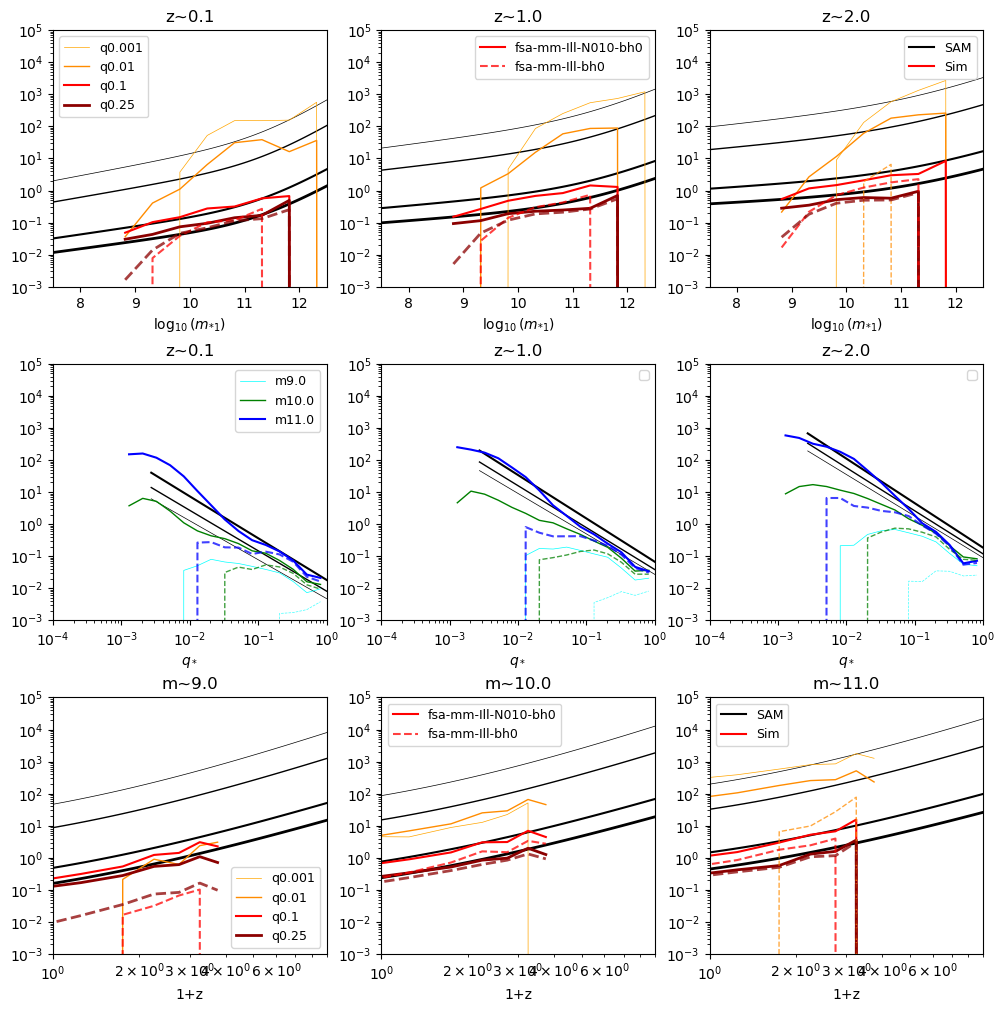

In [33]:



############     START HERE     ##################


##compare_gal_merger_rate(tng_dpops, sam_compare=[sam,sam_no_gpf],gpf_flag=[1,0], mcut=None)
##compare_gal_merger_rate(all_dpops, sam_compare=[sam,sam_no_gpf],gpf_flag=[1,0], mcut=None)
#compare_gal_merger_rate(all_fsa_dpops, sam_compare=[sam,sam_no_gpf],gpf_flag=[1,0], mcut=None)
#compare_gal_merger_rate(all_fsa_dpops, sam_compare=[sam,sam_no_gpf],gpf_flag=[1,0], mcut=None) #, verbose=True)


compare_gal_merger_rate(ill_fsa_bh0_dpops, sam_compare=[sam_no_gpf],gpf_flag=[0], mcut=None) #, verbose=True)
#compare_gal_merger_rate(tng_fsa_dpops, sam_compare=[sam_no_gpf],gpf_flag=[0], mcut=None) #, filename='compare_gmr_ill.png') 


In [ ]:
compare_gal_merger_rate(tng_fsa_bh0_dpops, sam_compare=[sam_no_gpf],gpf_flag=[0], mcut=None, filename='compare_gmr_tng100.png')


### Define subsets of discrete populations and print some key properties

In [ ]:
tng100_dpops = [d for d in tng_dpops if '100-' in d.lbl]
print('tng100_dpops:')
for d in tng100_dpops: print(d.lbl)
tng50_dpops = [d for d in tng_dpops if '50-' in d.lbl]
print('tng50_dpops:')
for d in tng50_dpops: print(d.lbl)
tng_hires_dpops = [d for d in tng_dpops if '-1' in d.lbl]
print('tng_hires_dpops:')
for d in tng_hires_dpops: print(d.lbl)
all_hires_dpops = [d for d in all_dpops if ('-1' in d.lbl or 'Ill' in d.lbl)]
print('all_hires_dpops:')
for d in all_hires_dpops: print(d.lbl)
for d in ill_fsa_lc_dpops: print(d.lbl)

all_hires_fsa_dpops = [d for d in all_fsa_dpops+ill_fsa_lc_dpops if ('-1' in d.lbl or 'Ill' in d.lbl)]
print('all_hires_fsa_dpops:')
for d in all_hires_fsa_dpops: print(d.lbl)
all_hires_fid_and_fsa_dpops = [d for d in all_hires_dpops+all_hires_fsa_dpops]
print('\nall_hires_fid_and_fsa_dpops:')
for d in all_hires_fid_and_fsa_dpops: print(d.lbl)


In [ ]:
print("coalescing fractions:")
print("\nsim data:")

#for dpop in all_sim_dpops:
for dpop in tng_dpops:
    frac = np.where(dpop.evo.coal)[0].size / dpop.evo.sepa[:,0].size 
    print(f"{dpop.lbl}: coalescing frac = {frac:.4g}")

print("\nfixed ainit and rescaled mmbulge:")
#for dpop in all_fsa_dpops:
for dpop in tng_fsa_dpops:
    frac = np.where(dpop.evo.coal)[0].size / dpop.evo.sepa[:,0].size 
    print(f"{dpop.lbl}: coalescing frac = {frac:.4g}")


In [ ]:
print("Number and fraction of binaries with log(Mtot)>9 and q>0.1:\n")
#for d in all_sim_dpops:
for d in tng_dpops:
    mt, mr = utils.mtmr_from_m1m2(d.pop.mass)
    lgmt = np.log10(mt/MSOL)
    print(f"{d.lbl}: {lgmt[(lgmt>9)&(mr>0.1)].size}, {lgmt[(lgmt>9)&(mr>0.1)].size/lgmt.size:.4g}")
    #print(lgmt[lgmt>9].size/lgmt.size)

##for pop in fsa_pop_list:
##for pop in fsa_pop_list+[rescale_fsa_pop_tng300_1]:
print('')
#for d in all_fsa_dpops:
for d in tng_fsa_dpops:
    mt, mr = utils.mtmr_from_m1m2(d.pop.mass)
    lgmt = np.log10(mt/MSOL)
    print(f"{d.lbl}: {lgmt[(lgmt>9)&(mr>0.1)].size}, {lgmt[(lgmt>9)&(mr>0.1)].size/lgmt.size:.4g}")
#    #print(lgmt[lgmt>9].size, lgmt[lgmt>9].size/lgmt.size)
#    #print(lgmt[lgmt>9].size/lgmt.size)
print('')

for d in all_dpops:
    mt, mr = utils.mtmr_from_m1m2(d.pop.mass)
    lgmt = np.log10(mt/MSOL)
    print(f"{d.lbl}: {lgmt[(lgmt>9)&(mr>0.1)].size}, {lgmt[(lgmt>9)&(mr>0.1)].size/lgmt.size:.4g}")


### Plot some key quantities for discrete populations

In [ ]:
for v in ['mass','mrat','sepa','redz']:
    compare_bin_pops(all_dpops, var=v)
    plt.legend()
    plt.show()

In [ ]:
for v in ['mass','mrat','redz']:
    compare_bin_pops(all_fsa_dpops, var=v)
    #compare_bin_pops([dpop_fsa_tng100_1.pop, dpop_fsa_tng100_2.pop], colors=colors, lws=lws,
    #                 labels=[dpop_fsa_tng100_1.lbl, dpop_fsa_tng100_2.lbl], var=v)
    #compare_bin_pops([d.pop for d in all_fsa_dpops], colors=colors, lws=lws,
    #                 labels=[d.lbl for d in all_fsa_dpops], var=v)
    plt.legend()
    plt.show()


In [ ]:
compare_bhmfs(tng_dpops)
plt.legend()
plt.show()

In [ ]:
compare_bhmfs(tng_fsa_dpops)
plt.legend()
plt.show()

In [ ]:
compare_gsmfs(tng_dpops)
plt.legend()
plt.show()

In [ ]:
compare_gsmfs(tng_fsa_dpops)
plt.legend()
plt.show()

In [ ]:
compare_gsmfs(all_hires_fid_and_fsa_dpops)
plt.legend()
plt.show()

In [ ]:
t50_hires_fid_and_fsa_dpops = [d for d in all_hires_fid_and_fsa_dpops if ('TNG50-' in d.lbl)]
print([d.lbl for d in t50_hires_fid_and_fsa_dpops])
t100_hires_fid_and_fsa_dpops = [d for d in all_hires_fid_and_fsa_dpops if ('TNG100-' in d.lbl)]
print([d.lbl for d in t100_hires_fid_and_fsa_dpops])
ill_hires_fid_and_fsa_dpops = [d for d in all_hires_fid_and_fsa_dpops if ('Ill' in d.lbl)]
print([d.lbl for d in ill_hires_fid_and_fsa_dpops])


In [ ]:
compare_gsmfs(all_fsa_dpops)
plt.legend()
plt.show()

In [ ]:
nrows = 2
ncols = 2
mass_type = 'pri'

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex='all', sharey='all', figsize=[10,10])
#print(axes.shape)
#print(axes.dtype)
#print(axes[0].shape)

if mass_type == 'pri':
    xlab = r'$\log_{10}(M_{bh,pri})$'
elif mass_type == 'tot':
    xlab = r'$\log_{10}(M_{bh,tot})$'
elif mass_type == 'all':
    xlab = r'$\log_{10}(M_{bh}) (all progenitors)$'

axes[0,0].set(yscale='log', 
              ylabel=r'BHMF [$(\log_{10} M)^{-1} Mpc^{-3}$]',
              xlim=(4.25,12.5), ylim=(1.0e-6,1.0))
axes[1,0].set(yscale='log',xlabel=xlab,
              ylabel=r'BHMF [$(\log_{10} M)^{-1} Mpc^{-3}$]',
              xlim=(4.25,12.5), ylim=(1.0e-6,1.0))
axes[1,1].set(yscale='log',xlabel=xlab,
              #ylabel=r'BHMF [$(\log_{10} M)^{-1} Mpc^{-3}$]',
              xlim=(4.25,12.5), ylim=(1.0e-6,1.0))
    
#dpop_lists = [t50_hires_fid_and_fsa_dpops, t100_hires_fid_and_fsa_dpops, ill_hires_fid_and_fsa_dpops]
dpop_lists = [ 
    [ d for d in all_hires_fid_and_fsa_dpops if d.lbl in ['TNG50-1', 'fsa-TNG50-1', 'fsa-TNG50-1-bh0'] ],
    [ d for d in all_hires_fid_and_fsa_dpops if d.lbl in ['TNG50-1-N100', 'fsa-TNG50-1-N100', 'fsa-TNG50-1-N100-bh0'] ],
    [ d for d in all_hires_fid_and_fsa_dpops if d.lbl in ['TNG100-1', 'fsa-TNG100-1', 'fsa-TNG100-1-bh0'] ],
    ill_hires_fid_and_fsa_dpops
    ]

for i in range(nrows):
    for j in range(ncols):
        
        if i+2*j >= (nrows*ncols): 
            break

        for dp in dpop_lists[i+2*j]:
            mtotbh, qbh = utils.mtmr_from_m1m2(dp.pop.mass)
            #print(f"{qbh.min()=} {qbh.max()=}")
            
            x,y = calc_bhmf(dp, mass_type=mass_type)
            axes[i,j].plot(x,y, lw=dp.lw, label=dp.lbl)
            
            xqcut,yqcut = calc_bhmf(dp, mask = (qbh>0.1), mass_type=mass_type)
            axes[i,j].plot(xqcut, yqcut, lw=dp.lw, label=dp.lbl+' q>0.1', alpha=0.4)

            axes[i,j].legend()

    else:
        continue  # only executed if the inner loop did NOT break
    break  # only executed if the inner loop DID break

fig.suptitle(f"BHMF for merging galaxies (mass type = {mass_type})")
fig.subplots_adjust(top=0.95, wspace=0.1, hspace=0.1)
plt.show()

In [ ]:
nrows = 2
ncols = 2
mass_type = 'tot'
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex='all', sharey='all', figsize=[10,9])
#print(axes.shape)
#print(axes.dtype)
#print(axes[0].shape)

if mass_type == 'pri':
    xlab = r'$\log_{10}(M_{*,pri})$'
elif mass_type == 'tot':
    xlab = r'$\log_{10}(M_{*,tot})$'
elif mass_type == 'all':
    xlab = r'$\log_{10}(M_{*}) (all progenitors)$'

axes[0,0].set(yscale='log', 
              ylabel=r'GSMF [$(\log_{10} M)^{-1} Mpc^{-3}$]',
              xlim=(7.25,15.5), ylim=(1.0e-6,1.0))
axes[1,0].set(yscale='log',xlabel=xlab,
              ylabel=r'BHMF [$(\log_{10} M)^{-1} Mpc^{-3}$]',
              xlim=(7.25,15.5), ylim=(1.0e-6,1.0))
axes[1,1].set(yscale='log',xlabel=xlab,
              #ylabel=r'BHMF [$(\log_{10} M)^{-1} Mpc^{-3}$]',
              xlim=(7.25,15.5), ylim=(1.0e-6,1.0))
    
#dpop_lists = [t50_hires_fid_and_fsa_dpops, t100_hires_fid_and_fsa_dpops, ill_hires_fid_and_fsa_dpops]
dpop_lists = [ 
    [ d for d in all_hires_fid_and_fsa_dpops if d.lbl in ['TNG50-1', 'fsa-TNG50-1', 'fsa-TNG50-1-bh0'] ],
    [ d for d in all_hires_fid_and_fsa_dpops if d.lbl in ['TNG50-1-N100', 'fsa-TNG50-1-N100', 'fsa-TNG50-1-N100-bh0'] ],
    [ d for d in all_hires_fid_and_fsa_dpops if d.lbl in ['TNG100-1', 'fsa-TNG100-1', 'fsa-TNG100-1-bh0'] ],
    ill_hires_fid_and_fsa_dpops
    ]

for i in range(nrows):
    for j in range(ncols):
        
        if i+2*j >= (nrows*ncols): 
            break

        for dp in dpop_lists[i+2*j]:
            qbulge = dp.pop.mbulge[:,0] / dp.pop.mbulge[:,1]
            qbulge[qbulge>1] = 1.0/qbulge[qbulge>1]
            #print(f"{qbulge.min()=} {qbulge.max()=}")
            
            x,y = calc_gsmf(dp, mass_type=mass_type)
            axes[i,j].plot(x,y, lw=dp.lw, label=dp.lbl)
            
            xqcut,yqcut = calc_gsmf(dp, mask = (qbulge>0.1), mass_type=mass_type)
            axes[i,j].plot(xqcut,yqcut, lw=dp.lw, label=dp.lbl+' q>0.1', alpha=0.4)
            
            axes[i,j].legend()

    else:
        continue  # only executed if the inner loop did NOT break
    break  # only executed if the inner loop DID break

fig.suptitle(f"GSMF for merging galaxies (mass type = {mass_type})")
fig.subplots_adjust(top=0.95, wspace=0.1, hspace=0.1)
plt.show()

### Load data for all subhalos & compare with merging subhalos

In [ ]:
import illustris_python as il
def calc_gsmf_from_snap(basePath,snapNum):
    subs = il.groupcat.loadSubhalos(basePath,snapNum,fields=['SubhaloLenType','SubhaloMassType',
                                                             'SubhaloMassInHalfRadType','SubhaloMassInRadType'])
    mstar = subs['SubhaloMassType'][:,4]*1.0e10/0.704
    Ngas = subs['SubhaloLenType'][:,0]
    Ndm = subs['SubhaloLenType'][:,1]
    Nstar = subs['SubhaloLenType'][:,4]
    Nbh = subs['SubhaloLenType'][:,5]
    
    mstar = mstar[(Ngas>100)&(Ndm>100)&(Nstar>100)&(Nbh>0)]
    lgmstar = np.log10(mstar)
    #print(lgmstar.min(),lgmstar.max())
    mstar_hist, bin_edges = np.histogram(lgmstar, bins=20)
    binsize = bin_edges[1:] - bin_edges[:-1]
    box_vol_mpc = 1357213.6324803103 # TNG100
    gsmf = mstar_hist / binsize / np.log(10) / box_vol_mpc # dex^-1 Mpc^-3
    #print(gsmf)
    #print(bin_edges)
    return gsmf, bin_edges

In [ ]:
tng100_1_basePath = '/orange/lblecha/IllustrisTNG/Runs/TNG100-1/output/'
gsmf_tng100_1_snap99, bin_edges_tng100_1_snap99 = calc_gsmf_from_snap(tng100_1_basePath,99) # z=0
gsmf_tng100_1_snap17, bin_edges_tng100_1_snap17 = calc_gsmf_from_snap(tng100_1_basePath,17) # z=5
#gsmf_tng100_1_snap33, bin_edges_tng100_1_snap33 = calc_gsmf_from_snap(tng100_1_basePath,33) # z=2
#gsmf_tng100_1_snap67, bin_edges_tng100_1_snap67 = calc_gsmf_from_snap(tng100_1_basePath,67) # z=0.5
##gsmf_tng100_1_snap72, bin_edges_tng100_1_snap72 = calc_gsmf_from_snap(tng100_1_basePath,72) # z=0.4

In [ ]:
tng50_1_basePath = '/orange/lblecha/IllustrisTNG/Runs/TNG50-1/output/'
gsmf_tng50_1_snap99, bin_edges_tng50_1_snap99 = calc_gsmf_from_snap(tng50_1_basePath,99) # z=0
gsmf_tng50_1_snap17, bin_edges_tng50_1_snap17 = calc_gsmf_from_snap(tng50_1_basePath,17) # z=5
#gsmf_tng50_1_snap33, bin_edges_tng50_1_snap33 = calc_gsmf_from_snap(tng50_1_basePath,33) # z=2
#gsmf_tng50_1_snap67, bin_edges_tng50_1_snap67 = calc_gsmf_from_snap(tng50_1_basePath,67) # z=0.5
##gsmf_tng50_1_snap72, bin_edges_tng50_1_snap72 = calc_gsmf_from_snap(tng50_1_basePath,72) # z=0.4

In [ ]:
mstar_arr = 10**np.arange(8.0,12.1,0.1) * MSOL


In [ ]:
#print(sam.mtot.shape, sam.mrat.shape, hard._sepa_init, hard._norm.shape)
#mass_stellar() returns (mstar_pri, mstar_rat, mstar_tot, redz)
mstar_pri,mstar_rat,mstar_tot,redz = sam.mass_stellar() 
print(mstar_pri.shape)
print(mstar_pri.min()/MSOL, mstar_pri.max()/MSOL)
#sam_dadt_vals = hard.dadt(sam.mtot, sam.mrat, np.repeat(hard._sepa_init,sam.mtot.size))
#print("mtot [msun]:",sam.mtot/MSOL)
#mstar_arr = 10**np.arange(8.0,12.1,0.1) * MSOL
print(mstar_arr.min()/MSOL, mstar_arr.max()/MSOL)

gsmf_func_z0 = sam._gsmf(mstar_arr, 0.0) / np.log(10)  # units of dex^-1 Mpc^-3
gsmf_func_z0pt4 = sam._gsmf(mstar_arr, 0.4) / np.log(10)  # units of dex^-1 Mpc^-3
gsmf_func_z0pt5 = sam._gsmf(mstar_arr, 0.5) / np.log(10)  # units of dex^-1 Mpc^-3
gsmf_func_z3 = sam._gsmf(mstar_arr, 3.0) / np.log(10)  # units of dex^-1 Mpc^-3
gsmf_func_z5 = sam._gsmf(mstar_arr, 5.0) / np.log(10)  # units of dex^-1 Mpc^-3
#print(sam._gsmf(mstar_arr, 0.0))
print(f"phi0={sam._gsmf._phi0}, phiz={sam._gsmf._phiz}")
print(f"log10(mchar0/msun)={np.log10(sam._gsmf._mchar0/MSOL):g}, log10(mcharz/msun)={np.log10(sam._gsmf._mcharz/MSOL):g}")
print(f"alpha0={sam._gsmf._alpha0}, alphaz={sam._gsmf._alphaz}")
plt.xscale('log')
plt.yscale('log')
plt.xlim(5.0e7,2.0e12)
plt.ylim(1.0e-6,0.01)
plt.plot(mstar_arr/MSOL, gsmf_func_z0, lw=3)
#plt.plot(mstar_arr/MSOL, gsmf_func_z0pt4, lw=3)
plt.plot(mstar_arr/MSOL, gsmf_func_z0pt5, lw=3)
plt.plot(mstar_arr/MSOL, gsmf_func_z5, lw=3)
plt.plot(mstar_pri.flatten()/MSOL, sam._gsmf(mstar_pri.flatten(), 0.0)/ np.log(10) ,'.',lw=0,ms=0.1,alpha=0.2)
plt.plot(mstar_pri.flatten()/MSOL, sam._gsmf(mstar_pri.flatten(), 5.0)/ np.log(10) ,'.',lw=0,ms=0.1,alpha=0.2)
phi_check_z0 = np.power(10.0, sam._gsmf._phi0 + sam._gsmf._phiz * 0.0)
m0_check = sam._gsmf._mchar0 / MSOL
plt.plot([1.0e8,1.0e12], [phi_check_z0, phi_check_z0])
plt.plot([m0_check,m0_check],[1.0e-6,1.0e-2],)

In [ ]:
##compare_gsmfs([d for d in tng_dpops], colors=colors, lws=lws,
##              labels=[d.lbl for d in tng_dpops])
##compare_gsmfs([d for d in [dpop_tng100_1,dpop_tng100_2]], colors=colors, lws=lws,
##              labels=[d.lbl for d in [dpop_tng100_1,dpop_tng100_2]])
##compare_gsmfs([tng100_dpops[0]])
#compare_gsmfs(all_hires_fid_and_fsa_dpops)
#box_vol_mpc = tng100_dpops[0].evo._sample_volume / (1.0e6*PC)**3
#print("box_vol_mpc = ", box_vol_mpc)
#plt.xlim(7.8,12.2)
##plt.plot(np.log10(mstar_arr/MSOL), gsmf_func_z0,'k',lw=2)
###plt.plot(np.log10(mstar_arr/MSOL), gsmf_func_z0pt4)
##plt.plot(np.log10(mstar_arr/MSOL), gsmf_func_z0pt5,'g',lw=2,label='SAM (z=0.5)')
##plt.plot(np.log10(mstar_arr/MSOL), gsmf_func_z5,'m',lw=2,label='SAM (z=5)')
##plt.plot(bin_edges_tng100_1_snap99[:-1],gsmf_tng100_1_snap99,'k--')
###plt.plot(bin_edges_snap72[:-1],gsmf_snap72)
#plt.plot(bin_edges_tng100_1_snap67[:-1],gsmf_tng100_1_snap67,'g--',label='TNG100-1 (all gals, z=0.5)')
#plt.plot(bin_edges_tng100_1_snap17[:-1],gsmf_tng100_1_snap17,'m--',label='TNG100-1 (all gals, z=5)')
#plt.legend()
#plt.show()

In [ ]:
#compare_gsmfs([tng50_dpops[0]])
#plt.xlim(7.8,12.2)
##plt.plot(np.log10(mstar_arr/MSOL), gsmf_func_z0,'k',lw=2)
##plt.plot(np.log10(mstar_arr/MSOL), gsmf_func_z0pt4)
#plt.plot(np.log10(mstar_arr/MSOL), gsmf_func_z0pt5,'g',lw=2,label='SAM (z=0.5)')
#plt.plot(np.log10(mstar_arr/MSOL), gsmf_func_z5,'m',lw=2,label='SAM (z=5)')
##plt.plot(bin_edges_snap99[:-1],gsmf_snap99,'k--')
##plt.plot(bin_edges_snap72[:-1],gsmf_snap72)
#plt.plot(bin_edges_tng100_1_snap67[:-1],gsmf_tng100_1_snap67,'g--',label='TNG50-1 (all gals, z=0.5)')
#plt.plot(bin_edges_tng100_1_snap17[:-1],gsmf_tng100_1_snap17,'m--',label='TNG50-1 (all gals, z=5)')
#plt.legend()
#plt.show()

In [ ]:
compare_gsmfs(tng_hires_dpops[:2])
#box_vol_mpc = dpop_tng50_1.evo._sample_volume / (1.0e6*PC)**3
#print("box_vol_mpc = ", box_vol_mpc)
plt.xlim(7.8,12.2)
#plt.plot(np.log10(mstar_arr/MSOL), gsmf_func_z0,'k',lw=2)
#plt.plot(np.log10(mstar_arr/MSOL), gsmf_func_z0pt4)
plt.plot(np.log10(mstar_arr/MSOL), gsmf_func_z0pt5,'g',lw=2,label='SAM (z=0.5)')
plt.plot(np.log10(mstar_arr/MSOL), gsmf_func_z3,'m',lw=2,label='SAM (z=3)')
##plt.plot(np.log10(mstar_arr/MSOL), gsmf_func_z5,'m',lw=2,label='SAM (z=5)')
##plt.plot(bin_edges_snap99[:-1],gsmf_snap99,'k--')
##plt.plot(bin_edges_snap72[:-1],gsmf_snap72)
#plt.plot(bin_edges_tng50_1_snap67[:-1],gsmf_tng50_1_snap67,'g--',label='TNG50-1 (all gals, z=0.5)')
##plt.plot(bin_edges_tng50_1_snap33[:-1],gsmf_tng50_1_snap33,'m:',label='TNG50-1 (all gals, z=3)')
###plt.plot(bin_edges_tng50_1_snap17[:-1],gsmf_tng50_1_snap17,'m:',label='TNG50-1 (all gals, z=5)')
#plt.plot(bin_edges_tng100_1_snap67[:-1],gsmf_tng100_1_snap67,'g--',label='TNG100-1 (all gals, z=0.5)')
##plt.plot(bin_edges_tng100_1_snap33[:-1],gsmf_tng100_1_snap33,'m:',label='TNG100-1 (all gals, z=3)')
###plt.plot(bin_edges_tng100_1_snap17[:-1],gsmf_tng100_1_snap17,'m:',label='TNG100-1 (all gals, z=5)')
plt.legend()
plt.show()

### Compare GMR directly with formulae from Rodriguez-Gomez+2015

In [ ]:
def rg15_merger_rate(Mtot, mu, z):
    M0 = 2.0e11 * MSOL
    A0 = 10.0**-2.2287 #± 0.0045
    eta = 2.4644 #± 0.0128
    alpha0 = 0.2241 #± 0.0038
    alpha1 = -1.1759 #± 0.0316
    beta0 = -1.2595 #± 0.0026
    beta1 = 0.0611 #± 0.0021
    gamma = -0.0477 #± 0.0013
    delta0 = 0.7668 #± 0.0202
    delta1 = -0.4695 #± 0.0440

    Az = A0 * (1 + z)**eta
    alphaz = alpha0 * (1 + z)**alpha1
    betaz = beta0 * (1 + z)**beta1
    deltaz = delta0 * (1 + z)**delta1
    
    gmr = Az * (Mtot / (1.0e10*MSOL))**alphaz * (1 + (Mtot/M0)**deltaz) 
    gmr = gmr * mu**(betaz + gamma*np.log10(Mtot / (1.0e10*MSOL)))
    
    return gmr

In [ ]:
mstar_pri, mstar_rat, mstar_tot, redz = sam.mass_stellar() 
rg15_gmr = rg15_merger_rate(mstar_tot, mstar_rat, redz)
def get_index(arr,val):
    diff = np.abs(arr-val)
    index =  np.where(diff==diff.min())[0][0]
    return index

mu0pt25_ix = get_index(mstar_rat[0,:,0],0.25)
mu0pt01_ix = get_index(mstar_rat[0,:,0],0.01)
m9_ix = get_index(mstar_tot[:,0,0],1.0e9*MSOL)
m10_ix = get_index(mstar_tot[:,0,0],1.0e10*MSOL)
m11_ix = get_index(mstar_tot[:,0,0],1.0e11*MSOL)
z0pt1_ix = get_index(redz[0,0,:],0.1)
print(z0pt1_ix, mu0pt25_ix, mu0pt01_ix)
#print(mstar_rat[-1,:,0])
#print(redz[0,0,:])
#print(mstar_tot[:,0,0]/MSOL)
#print(mstar_tot[:,-1,0]/MSOL)
print(rg15_gmr.shape)
print(mstar_tot.shape)
print(sam.mrat)
print(mstar_rat[0,:,0])

sam_gmr = sam_no_gpf._gal_merger_rate(mstar_tot, mstar_rat, redz) * GYR # convert from s^-1 to Gyr^-1
print(f"sam_gmr shape: {sam_gmr.shape}")

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(131)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('stellar mass')
ax1.set_ylabel('Galaxy merger rate [Gyr^-1]')
ax1.plot(mstar_tot[:,0,z0pt1_ix]/MSOL, rg15_gmr[:,0,z0pt1_ix], label=f'mu={mstar_rat[0,0,0]:.4g}')
ax1.plot(mstar_tot[:,mu0pt01_ix,z0pt1_ix]/MSOL, rg15_gmr[:,mu0pt01_ix,z0pt1_ix],
         label=f'mu={mstar_rat[0,mu0pt01_ix,0]:.4g}')
ax1.plot(mstar_tot[:,mu0pt25_ix,z0pt1_ix]/MSOL, rg15_gmr[:,mu0pt25_ix,z0pt1_ix],
         label=f'mu={mstar_rat[0,mu0pt25_ix,0]:.4g}')

ax1.plot(mstar_tot[:,0,z0pt1_ix]/MSOL, sam_gmr[:,0,z0pt1_ix],'--')
ax1.plot(mstar_tot[:,mu0pt01_ix,z0pt1_ix]/MSOL, sam_gmr[:,mu0pt01_ix,z0pt1_ix],'--')
ax1.plot(mstar_tot[:,mu0pt25_ix,z0pt1_ix]/MSOL, sam_gmr[:,mu0pt25_ix,z0pt1_ix],'--')

ax1.legend()

ax2 = fig.add_subplot(132)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('stellar mass ratio')
ax2.set_ylabel('Galaxy merger rate [Gyr^-1]')
ax2.plot(mstar_rat[0,:,z0pt1_ix],rg15_gmr[0,:,z0pt1_ix],label=f'M={mstar_tot[0,0,0]/MSOL:.4g}')
ax2.plot(mstar_rat[m9_ix,:,z0pt1_ix],rg15_gmr[m9_ix,:,z0pt1_ix],
         label=f'M={mstar_tot[m9_ix,0,0]/MSOL:.4g}')
ax2.plot(mstar_rat[m10_ix,:,z0pt1_ix], rg15_gmr[m10_ix,:,z0pt1_ix],
         label=f'M={mstar_tot[m10_ix,0,0]/MSOL:.4g}')
ax2.plot(mstar_rat[m11_ix,:,z0pt1_ix], rg15_gmr[m11_ix,:,z0pt1_ix],
         label=f'M={mstar_tot[m11_ix,0,0]/MSOL:.4g}')

ax2.plot(mstar_rat[0,:,z0pt1_ix], sam_gmr[0,:,z0pt1_ix],'--')
ax2.plot(mstar_rat[m9_ix,:,z0pt1_ix], sam_gmr[m9_ix,:,z0pt1_ix],'--')
ax2.plot(mstar_rat[m10_ix,:,z0pt1_ix], sam_gmr[m10_ix,:,z0pt1_ix],'--')
ax2.plot(mstar_rat[m11_ix,:,z0pt1_ix], sam_gmr[m11_ix,:,z0pt1_ix],'--')

ax2.legend()

print("shapes:")
print(redz[m9_ix,mu0pt01_ix,:].shape)
print(rg15_gmr[m9_ix,mu0pt01_ix:,:].shape)
print(mstar_rat[m9_ix,mu0pt01_ix:,:].shape)
print(utils.trapz(rg15_gmr[m9_ix,mu0pt01_ix:,:],mstar_rat[0,mu0pt01_ix:,0],axis=0,cumsum=False).shape)
print(utils.trapz(rg15_gmr[m9_ix,mu0pt01_ix:,:],mstar_rat[0,mu0pt01_ix:,0],axis=0,cumsum=False).sum(axis=0).shape)
#rg15_gmr_cum_mu = 
#sam_dngalgal_dz = utils.trapz(integ, mstar_rat_arr, axis=1, cumsum=False)                
#sam_dngalgal_dz = sam_dngalgal_dz.sum(axis=0)
ax3 = fig.add_subplot(133)
ax3.set_xlim(1,10)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('1+z')
ax3.set_ylabel('Galaxy merger rate [Gyr^-1]')
ax3.plot(1+redz[m11_ix,mu0pt01_ix,:],
         utils.trapz(rg15_gmr[m11_ix,mu0pt01_ix:,:],mstar_rat[0,mu0pt01_ix:,0],axis=0,cumsum=False).sum(axis=0),
         label=f'M={mstar_tot[m11_ix,mu0pt01_ix,0]/MSOL:.4g},mu>={mstar_rat[m11_ix,mu0pt01_ix,0]:.4g}')
ax3.plot(1+redz[m11_ix,mu0pt25_ix,:],
         utils.trapz(rg15_gmr[m11_ix,mu0pt25_ix:,:],mstar_rat[0,mu0pt25_ix:,0],axis=0,cumsum=False).sum(axis=0),
         label=f'M={mstar_tot[m11_ix,mu0pt25_ix,0]/MSOL:.4g},mu>={mstar_rat[m11_ix,mu0pt25_ix,0]:.4g}')
ax3.plot(1+redz[m10_ix,mu0pt25_ix,:],
         utils.trapz(rg15_gmr[m10_ix,mu0pt25_ix:,:],mstar_rat[0,mu0pt25_ix:,0],axis=0,cumsum=False).sum(axis=0),
         label=f'M={mstar_tot[m10_ix,mu0pt25_ix,0]/MSOL:.4g},mu>={mstar_rat[m10_ix,mu0pt25_ix,0]:.4g}')
ax3.plot(1+redz[m9_ix,mu0pt25_ix,:],
         utils.trapz(rg15_gmr[m9_ix,mu0pt25_ix:,:],mstar_rat[0,mu0pt25_ix:,0],axis=0,cumsum=False).sum(axis=0),
         label=f'M={mstar_tot[m9_ix,mu0pt25_ix,0]/MSOL:.4g},mu>={mstar_rat[m9_ix,mu0pt25_ix,0]:.4g}')

ax3.plot(1+redz[m11_ix,mu0pt01_ix,:],
         utils.trapz(sam_gmr[m11_ix,mu0pt01_ix:,:],
                     mstar_rat[0,mu0pt01_ix:,0],axis=0,cumsum=False).sum(axis=0),'--')
ax3.plot(1+redz[m11_ix,mu0pt25_ix,:],
         utils.trapz(sam_gmr[m11_ix,mu0pt25_ix:,:],
                     mstar_rat[0,mu0pt25_ix:,0],axis=0,cumsum=False).sum(axis=0),'--')
ax3.plot(1+redz[m10_ix,mu0pt25_ix,:],
         utils.trapz(sam_gmr[m10_ix,mu0pt25_ix:,:],
                     mstar_rat[0,mu0pt25_ix:,0],axis=0,cumsum=False).sum(axis=0),'--')
ax3.plot(1+redz[m9_ix,mu0pt25_ix,:],
         utils.trapz(sam_gmr[m9_ix,mu0pt25_ix:,:],
                     mstar_rat[0,mu0pt25_ix:,0],axis=0,cumsum=False).sum(axis=0),'--')

#ax3.plot(1+redz[m10_idx,mu0pt01_idx,:],rg15_gmr[m10_idx,mu0pt01_idx,:],
#         label=f'M={mstar_tot[m10_idx,mu0pt01_idx,0]/MSOL:.4g},mu>={mstar_rat[m10_idx,mu0pt01_idx,0]:.4g}')
#ax3.plot(1+redz[m11_idx,mu0pt01_idx,:],rg15_gmr[m11_idx,mu0pt01_idx,:],
#         label=f'M={mstar_tot[m11_idx,mu0pt01_idx,0]/MSOL:.4g},mu>={mstar_rat[m11_idx,mu0pt01_idx,0]:.4g}')
#ax3.plot(redz[m9_idx,:,z0pt1_idx],rg15_gmr[m9_idx,:,z0pt1_idx],
#         label=f'M={mstar_tot[m9_idx,0,z0pt1_idx]/MSOL:.4g}')
#ax2.plot(mstar_rat[m10_idx,:,z0pt1_idx], rg15_gmr[m10_idx,:,z0pt1_idx],
#         label=f'M={mstar_tot[m10_idx,0,z0pt1_idx]/MSOL:.4g}')
#ax2.plot(mstar_rat[m11_idx,:,z0pt1_idx], rg15_gmr[m11_idx,:,z0pt1_idx],
#         label=f'M={mstar_tot[m11_idx,0,z0pt1_idx]/MSOL:.4g}')
#ax1.plot(mstar_tot[:,-1,0]/MSOL,rg15_gmr[:,-1,0],label=f'mu={mstar_rat[0,-1,0]:.4g}')
ax3.legend()

### Compare galaxy merger densities and galaxy merger rates b/t sims & SAMs:

In [ ]:
##compare_gal_merger_dens([d for d in [dpop_tng100_1,dpop_tng100_2]],sam_compare=sam)
compare_gal_merger_dens(all_fsa_dpops, sam_compare=[sam,sam_no_gpf], #ill_hires_fid_and_fsa_dpops,
#compare_gal_merger_dens(all_hires_fid_and_fsa_dpops, sam_compare=[sam],
                        gpf_flag=[1,0],legend=False) #,  
##                        mcut=1.0e10*MSOL, qcut=0.1)
#compare_gal_merger_dens(all_hires_fid_and_fsa_dpops) #,  

In [ ]:
#compare_gal_merger_dens(t50_hires_fid_and_fsa_dpops, sam_compare=[sam,sam_no_gpf],
compare_gal_merger_dens(all_dpops, sam_compare=[sam,sam_no_gpf],
                        gpf_flag=[1,0],legend=True) 

In [ ]:
#compare_gal_merger_rate([d for d in [dpop_tng100_1,dpop_tng100_2]],sam_compare=sam)
compare_gal_merger_rate([], sam_compare=[sam,sam_no_gpf], gpf_flag=[1,0], legend=False) #,mcut=1.0e10*MSOL,qcut=0.1)

In [ ]:




##compare_gal_merger_rate(tng_dpops, sam_compare=[sam,sam_no_gpf],gpf_flag=[1,0], mcut=None)
##compare_gal_merger_rate(all_dpops, sam_compare=[sam,sam_no_gpf],gpf_flag=[1,0], mcut=None)
#compare_gal_merger_rate(all_fsa_dpops, sam_compare=[sam,sam_no_gpf],gpf_flag=[1,0], mcut=None)
#compare_gal_merger_rate(all_fsa_dpops, sam_compare=[sam,sam_no_gpf],gpf_flag=[1,0], mcut=None)


In [ ]:
mstar_pri, mstar_rat, mstar_tot, redz = sam.mass_stellar() 
#print(mstar_pri.shape, mstar_rat.shape, mstar_tot.shape, redz.shape)
#print("dens_gal_gal and mstar shapes:")

#sam_no_gpf._ndens_gal(mstar_pri, mstar_rat, redz)


In [ ]:
sepa_arr = np.logspace(1.0e-6*PC, hard._sepa_init, 101)
mt, mr, sepa, norm = np.broadcast_arrays(
            sam.mtot[:, np.newaxis, np.newaxis],
            sam.mrat[np.newaxis, :, np.newaxis],
            sepa_arr[np.newaxis, np.newaxis, :],
            hard._norm[:, :, np.newaxis],
        )
print(mt.shape, mr.shape, sepa.shape)
dadt_sam = hard.dadt(mt, mr, sepa, norm)
print(dadt_sam.shape)

### Plot amplitudes at 1/yr, 1/3yr, and 1/10yr

In [ ]:
#for d in tng_dpops + tng_fsa_dpops: #all_sim_dpops + all_fsa_dpops:
#for d in all_hires_fid_and_fsa_dpops: 
#for d in all_fsa_dpops: 
for d in all_dpops: 
    d.get_amplitudes_at_freqs()
for d in all_fsa_dpops: 
    d.get_amplitudes_at_freqs()

## this is sketch. only works if freqs is same for all dpops and for sam
ayr_sam = gwb_sam[d.idx_ayr,:].flatten()
a3yr_sam = gwb_sam[d.idx_a3yr,:].flatten()
a10yr_sam = gwb_sam[d.idx_a10yr,:].flatten()

ayr_sam_no_gpf = gwb_sam_no_gpf[d.idx_ayr,:].flatten()
a3yr_sam_no_gpf = gwb_sam_no_gpf[d.idx_a3yr,:].flatten()
a10yr_sam_no_gpf = gwb_sam_no_gpf[d.idx_a10yr,:].flatten()


In [ ]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)

kale.dist1d(np.log10(ayr_sam), density=True, hist=False, confidence=True, carpet=False, 
            lw=4, color='k', label='SAM')
kale.dist1d(np.log10(ayr_sam_no_gpf), density=True, hist=False, confidence=True, carpet=False, 
            lw=4, color='orchid', label='SAM (no GPF)')
#for i in np.arange(len(tng_dpops)):
for d in all_dpops:
    if np.any(~np.isfinite(d.ayr)):
        print(f"skipping {d.lbl}")
        print(f"{d.ayr.min()}, {d.ayr.max()}")
    else:
        print(f"{d.lbl}")
        print(f"{d.ayr.min()}, {d.ayr.max()}")
        kale.dist1d(np.log10(d.ayr), density=True, hist=False, confidence=False, carpet=False, 
                    label=d.lbl, lw=d.lw, color=d.color,alpha=0.5)
for d in [all_fsa_dpops[0],all_fsa_dpops[2]]:
    if np.any(~np.isfinite(d.ayr)):
        print(f"skipping {d.lbl}")
        print(f"{d.ayr.min()}, {d.ayr.max()}")
    else:
        print(f"{d.lbl}")
        print(f"{d.ayr.min()}, {d.ayr.max()}")
        kale.dist1d(np.log10(d.ayr), density=True, hist=False, confidence=False, carpet=False, 
                    label=d.lbl, lw=d.lw, color=d.color,alpha=0.5)

plt.title("Comparison of GWB amplitudes at 1/yr")
plt.legend()
#fig.savefig(f'compare_dpops_tau{tau/(1e9*YR):.1f}_A1yr.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{3yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)

kale.dist1d(np.log10(a3yr_sam), density=True, hist=False, confidence=True, carpet=False, 
            lw=4, color='k', label='SAM')
kale.dist1d(np.log10(a3yr_sam_no_gpf), density=True, hist=False, confidence=True, carpet=False, 
            lw=4, color='orchid', label='SAM (no GPF)')
#for i in np.arange(len(tng_dpops)):
for d in all_fsa_dpops:
    if np.any(~np.isfinite(d.a3yr)):
        print(f"skipping {d.lbl}")
        print(f"{d.a3yr.min()}, {d.a3yr.max()}")
    else:
        print(f"{d.lbl}")
        print(f"{d.a3yr.min()}, {d.a3yr.max()}")
        kale.dist1d(np.log10(d.a3yr), density=True, hist=False, confidence=False, carpet=False, 
                    label=d.lbl, lw=d.lw, color=d.color,alpha=0.5)
    #kale.dist1d(np.log10(tng_fsa_dpops[i].a3yr), density=True, hist=False, confidence=False, carpet=False, 
    #            label=tng_fsa_dpops[i].lbl, lw=lws[i], color=colors[i],ls='--')

plt.title("Comparison of GWB amplitudes at 1/3yr")
plt.legend()
#fig.savefig(f'compare_dpops_tau{tau/(1e9*YR):.1f}_A0.33yr.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{10yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)

kale.dist1d(np.log10(a10yr_sam), density=True, hist=False, confidence=True, carpet=False, 
            lw=4, color='k', label='SAM')
kale.dist1d(np.log10(a10yr_sam_no_gpf), density=True, hist=False, confidence=True, carpet=False, 
            lw=4, color='orchid', label='SAM (no GPF)')
#for i in np.arange(len(tng_dpops)):    
for d in all_fsa_dpops:
    if np.any(~np.isfinite(d.a10yr)):
        print(f"skipping {d.lbl}")
        print(f"{d.a10yr.min()}, {d.a10yr.max()}")
    else:
        print(f"{d.lbl}")
        print(f"{d.a10yr.min()}, {d.a10yr.max()}")
        kale.dist1d(np.log10(d.a10yr), density=True, hist=False, confidence=False,  carpet=False, 
                    label=d.lbl, lw=d.lw, color=d.color,alpha=0.5)
        #kale.dist1d(np.log10(tng_fsa_dpops[i].a10yr), density=True, hist=False, confidence=False,  carpet=False, 
        #            label=tng_fsa_dpops[i].lbl, lw=lws[i], color=colors[i], ls='--')
    
#kale.dist1d(np.log10(a10yr_fsa_new_ill), density=True, confidence=False, label='a10yr_fsa_new_ill',color='m')
#kale.dist1d(np.log10(a10yr_sam), density=True, confidence=True, label='a10yr_sam')
plt.title("Comparison of GWB amplitudes at 1/10yr")
plt.legend()
#fig.savefig(f'compare_dpops_tau{tau/(1e9*YR):.1f}_A0.1yr.png')
plt.show()

In [ ]:
def __plot_gwb(fobs, gwb, hc_ss=None, bglabel=None, sslabel=None, **kwargs):
    xx = fobs * YR
    fig, ax = figax(
        xlabel=LABEL_GW_FREQUENCY_YR,
        ylabel=LABEL_CHARACTERISTIC_STRAIN
    )
    if(hc_ss is not None):
        draw_ss_and_gwb(ax, xx, hc_ss, gwb, sslabel=sslabel,
                        bglabel=bglabel, **kwargs)
    else:
        draw_gwb(ax, xx, gwb, **kwargs)
    _twin_hz(ax)
    return fig

def __draw_gwb(ax, xx, gwb, nsamp=10, color=None, label=None, **kwargs):
    if color is None:
        color = ax._get_lines.get_next_color()

    kw_plot = kwargs.pop('plot', {})
    kw_plot.setdefault('color', color)
    hh = __draw_med_conf(ax, xx, gwb, plot=kw_plot, label=label, **kwargs)
    if (nsamp is not None) and (nsamp > 0):
        nsamp_max = gwb.shape[1]
        idx = np.random.choice(nsamp_max, np.min([nsamp, nsamp_max]), replace=False)
        for ii in idx:
            ax.plot(xx, gwb[:, ii], color=color, alpha=0.25, lw=1.0, ls='-')

    return hh

def __draw_med_conf(ax, xx, vals, fracs=[0.50, 0.90], weights=None, plot={}, 
                    fill={}, filter=False, label=None, lw=1.0, ls='-'):
    #plot.setdefault('alpha', 0.75)
    #fill.setdefault('alpha', 0.2)
    plot.setdefault('alpha', 0.75)
    fill.setdefault('alpha', 0.2)
    percs = np.atleast_1d(fracs)
    assert np.all((0.0 <= percs) & (percs <= 1.0))

    # center the target percentages into pairs around 50%, e.g.  68 ==> [16,84]
    inter_percs = [[0.5-pp/2, 0.5+pp/2] for pp in percs]
    # Add the median value (50%)
    inter_percs = [0.5, ] + np.concatenate(inter_percs).tolist()
    # Get percentiles; they go along the last axis
    if filter:
        rv = [
            kale.utils.quantiles(vv[vv > 0.0], percs=inter_percs, weights=weights)
            for vv in vals
        ]
        rv = np.asarray(rv)
    else:
        rv = kale.utils.quantiles(vals, percs=inter_percs, weights=weights, axis=-1)

    med, *conf = rv.T
    # plot median
    hh, = ax.plot(xx, med, **plot, lw=lw, ls=ls, label=label)

    # Reshape confidence intervals to nice plotting shape
    # 2*P, X ==> (P, 2, X)
    conf = np.array(conf).reshape(len(percs), 2, xx.size)

    kw = dict(color=hh.get_color())
    kw.update(fill)
    fill = kw

    # plot each confidence interval
    for lo, hi in conf:
        gg = ax.fill_between(xx, lo, hi, **fill)

    return (hh, gg)

In [ ]:
LABEL_GW_FREQUENCY_YR = r"GW Frequency $[\mathrm{yr}^{-1}]$"
LABEL_GW_FREQUENCY_HZ = r"GW Frequency $[\mathrm{Hz}]$"
LABEL_GW_FREQUENCY_NHZ = r"GW Frequency $[\mathrm{nHz}]$"
LABEL_SEPARATION_PC = r"Binary Separation $[\mathrm{pc}]$"
LABEL_CHARACTERISTIC_STRAIN = r"GW Characteristic Strain"
LABEL_HARDENING_TIME = r"Hardening Time $[\mathrm{Gyr}]$"
LABEL_CLC0 = r"$C_\ell / C_0$"

fig, ax = plot.figax(
    xlabel=LABEL_GW_FREQUENCY_YR,
    ylabel=LABEL_CHARACTERISTIC_STRAIN
)

frac = 0.50

xx = d.freqs * YR
print(f"{xx.size=}, {gwb_sam.shape=}")
__draw_gwb(ax, xx, gwb_sam, nsamp=0, color='k', label='SAM',lw=3,fracs=[frac])
#__draw_gwb(ax, xx, gwb_sam, nsamp=0, color='k', label='SAM (GPF+GMT)',lw=2)
#__draw_gwb(ax, xx, gwb_sam_no_gpf, nsamp=0, color='m', label='SAM (GMR)')
#color = ['darkgreen','purple']
#lw = [
#for d in all_fsa_dpops:
xx = all_fsa_dpops[0].freqs * YR
print(f"{all_fsa_dpops[0].gwb.back.shape=}")
#__draw_gwb(ax, xx, all_fsa_dpops[0].gwb.back, nsamp=0, color=color[0], label=all_fsa_dpops[0].lbl,lw=1.5)
__draw_gwb(ax, xx, all_dpops[0].gwb.back, nsamp=0, color='g', 
           label='Illustris',lw=1.5,fracs=[frac])
__draw_gwb(ax, xx, all_dpops[1].gwb.back, nsamp=0, color='m', 
           label='TNG100',lw=1.5,fracs=[frac])

__draw_gwb(ax, xx, all_fsa_dpops[0].gwb.back, nsamp=0, color='darkgreen', 
           label='Illustris-mod',lw=2,ls='--',fracs=[frac])

xx = all_fsa_dpops[1].freqs * YR
print(f"{all_fsa_dpops[1].gwb.back.shape=}")
__draw_gwb(ax, xx, all_fsa_dpops[1].gwb.back, nsamp=0, color='purple', 
           label='TNG100-mod',lw=2,ls='--',fracs=[frac])

plt.legend(loc='lower left',fontsize=12)
plt.savefig('gwb_compare_ill_tng100_main.png',dpi=300)

In [ ]:
#print(gwb_old_ill.back.shape, gwb_old_ill.fore.shape, gwb_old_ill.loudest.shape)
##plot.plot_gwb(freqs, gwb_new_ill_nst.back)
#print(freqs)
#print(gwb_old_ill.back)
for d in all_fsa_dpops:
    plot.plot_gwb(d.freqs, d.gwb.back) #, ylim=(5.0e-17,2.0e-14))
    plt.title(d.lbl)
#plot.plot_gwb(freqs, gwb_tng50_3.back, ylim=(5.0e-17,2.0e-14))
##plot.plot_gwb(freqs, gwb_sam, ylim=(5.0e-17,2.0e-14))

plt.show()

In [ ]:
sepa = np.logspace(-4.5, 5, 100) * PC
fig, ax = plot.figax(figsize=(8,5))
for d in tng_dpops:
    plot_evo(d.evo, freqs=None, sepa=sepa, ax=ax)
    plt.title(d.lbl)
    #plot_evo(evo_tng50_3, freqs=None, sepa=sepa, ax=ax)
plt.legend()
plt.show()

In [ ]:
sepa = np.logspace(-4.5, 5, 100) * PC
fig, ax = plot.figax(figsize=(8,5))
for d in tng_fsa_dpops:
    plot_evo(d.evo, freqs=None, sepa=sepa, ax=ax)
    plt.title(d.lbl)
#plt.legend()
plt.show()

In [ ]:
# Calculate the total lifetime of each binary
ncols = 2
nrows = 3
fig, axes = plot.figax(scale='lin', xlabel='Time: actual/specified', ylabel='density',figsize=(8,5),
                       ncols=ncols, nrows=nrows, wspace=0.3,hspace=0.3)
#times = [evo_old_ill.tlook, evo_new_ill.tlook, evo_tng100_1.tlook, evo_tng300_1.tlook, hard.tlook]
times = [dpop_tng100_1.evo.tlook, dpop_tng300_1.evo.tlook] #, hard.tlook]
print(len(times))
i = 0
for idx,ax in np.ndenumerate(axes):
    i = idx[0]*ncols + idx[1]
    if i >= len(times): break
    print(times[i].shape)
    print(f"idx: {idx}, i: {i}")
    dt = times[i][:, 0] - times[i][:, -1]
    # Create figure
    # use kalepy to plot distribution
    kale.dist1d(dt/tau, density=True, ax=ax)
    #ax.legend()
    
plt.show()

In [ ]:
for d in tng_dpops:
    plot_bin_pop(d.pop)
plt.show()

In [ ]:
#plot_mbh_scaling_relations(fsa_pop_old_ill)
#plot_mbh_scaling_relations(pop_new_ill)
#plot_mbh_scaling_relations(pop_tng100_1)
#plot_mbh_scaling_relations(pop_tng300_1)
#plot_mbh_scaling_relations(pop_old_ill,compare_pops=[pop_new_ill,pop_tng100_1,pop_tng300_1], ncols=2, nrows=2)
plot_mbh_scaling_relations(dpop_new_ill.pop, compare_pops=[d.pop for d in tng_fsa_dpops], 
                           ncols=4, nrows=2,
                           xlim=(6.5,13.2), ylim=(4.5,11.1))
plt.savefig('mmbulge_relations.png')
plt.show()

In [ ]:
dpop_new_ill.pop.mbulge.shape

In [ ]:
dpop_tng100_1.pop.mbulge.shape

In [ ]:
## ---- Set the fixed binary lifetime
##tau = 2.0 * GYR 
#tau = 1.0 * GYR 
####################################

#fixed_sepa = 1.0e4 * PC

## construct sampling frequencies
##freqs = holo.utils.nyquist_freqs(dur=20.0*YR, cad=0.25*YR, lgspace=True)
##freqs_edges = holo.utils.nyquist_freqs_edges(dur=20.0*YR, cad=0.25*YR, lgspace=True)
#freqs, freqs_edges = utils.pta_freqs()
#### freqs, freq_edges = holo.librarian.get_freqs(None) ## doesn't work for Discrete_GW
##print(freqs)
##print(np.log10(freqs))
#print(freqs.size)

#colors = ['r', 'orange', 'y', 'blue', 'c', 'm', 'orchid', 'k', 'k', 'k', 'k'] #, 'c']
#lws = [3.5, 2.5, 1.5, 2.5, 1.5, 2.5, 1.0, 1.0, 1.0, 1.0]

In [ ]:
##dpop_old_ill = Discrete(freqs, freqs_edges, fname=None, lbl="oldIll", tau=tau, fixed_sepa=None)
##dpop_fsa_old_ill = Discrete(freqs, freqs_edges, fname=None, lbl="fsaOldIll", tau=tau, 
##                            fixed_sepa=fixed_sepa, mod_mmbulge=True)

#dpop_new_ill = Discrete(freqs, freqs_edges, lbl="newIll", tau=tau, fixed_sepa=None, 
#                        fname='galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5')
#dpop_fsa_new_ill = Discrete(freqs, freqs_edges, lbl="fsaNewIll", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
#                            fname='galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5')


In [ ]:
#### TNG100 ####

#dpop_tng100_1 = Discrete(freqs, freqs_edges, lbl="TNG100-1", tau=tau, fixed_sepa=None, 
#                         fname='galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5')
#dpop_fsa_tng100_1 = Discrete(freqs, freqs_edges, lbl="fsaTNG100-1", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
#                             fname='galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5')

#dpop_tng100_2 = Discrete(freqs, freqs_edges, lbl="TNG100-2", tau=tau, fixed_sepa=None, 
#                         fname='galaxy-mergers_TNG100-2_gas-012_dm-012_star-012_bh-001.hdf5')
#dpop_fsa_tng100_2 = Discrete(freqs, freqs_edges, lbl="fsaTNG100-2", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
#                             fname='galaxy-mergers_TNG100-2_gas-012_dm-012_star-012_bh-001.hdf5')


In [ ]:
#### TNG300 ####

#dpop_tng300_1 = Discrete(freqs, freqs_edges, lbl="TNG300-1", tau=tau, fixed_sepa=None, 
#                          fname='galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5')
#dpop_fsa_tng300_1 = Discrete(freqs, freqs_edges, lbl="fsaTNG300-1", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
#                             fname='galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5')


In [ ]:
#### TNG50 ####

#dpop_tng50_1 = Discrete(freqs, freqs_edges, lbl="TNG50-1", tau=tau, fixed_sepa=None, 
#                        fname='galaxy-mergers_TNG50-1_gas-800_dm-800_star-800_bh-001.hdf5')
#dpop_fsa_tng50_1 = Discrete(freqs, freqs_edges, lbl="fsaTNG50-1", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
#                            fname='galaxy-mergers_TNG50-1_gas-800_dm-800_star-800_bh-001.hdf5')

#dpop_tng50_2 = Discrete(freqs, freqs_edges, lbl="TNG50-2", tau=tau, fixed_sepa=None, 
#                        fname='galaxy-mergers_TNG50-2_gas-100_dm-100_star-100_bh-001.hdf5')
#dpop_fsa_tng50_2 = Discrete(freqs, freqs_edges, lbl="fsaTNG50-2", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
#                            fname='galaxy-mergers_TNG50-2_gas-100_dm-100_star-100_bh-001.hdf5')

#dpop_tng50_3 = Discrete(freqs, freqs_edges, lbl="TNG50-3", tau=tau, fixed_sepa=None, 
#                        fname='galaxy-mergers_TNG50-3_gas-012_dm-012_star-012_bh-001.hdf5')
#dpop_fsa_tng50_3 = Discrete(freqs, freqs_edges, lbl="fsaTNG50-3", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
#                            fname='galaxy-mergers_TNG50-3_gas-012_dm-012_star-012_bh-001.hdf5')


In [ ]:
##all_sim_dpops = [dpop_old_ill, dpop_new_ill, dpop_tng50_1, dpop_tng50_2, 
##                 dpop_tng50_3, dpop_tng100_1, dpop_tng100_2, dpop_tng300_1]
##all_fsa_dpops = [dpop_fsa_old_ill, dpop_fsa_new_ill, dpop_fsa_tng50_1, dpop_fsa_tng50_2, 
##                 dpop_fsa_tng50_3, dpop_fsa_tng100_1, dpop_fsa_tng100_2, dpop_fsa_tng300_1]
#all_sim_dpops = [dpop_new_ill, dpop_tng50_1, dpop_tng50_2, 
#                 dpop_tng50_3, dpop_tng100_1, dpop_tng100_2, dpop_tng300_1]
#all_fsa_dpops = [dpop_fsa_new_ill, dpop_fsa_tng50_1, dpop_fsa_tng50_2, 
#                 dpop_fsa_tng50_3, dpop_fsa_tng100_1, dpop_fsa_tng100_2 , dpop_fsa_tng300_1]

##tng_dpops = [dpop_tng100_1, dpop_tng100_2] #, dpop_tng300_1]
##tng_fsa_dpops = [dpop_fsa_tng100_1, dpop_fsa_tng100_2] #, dpop_tng300_1]

#tng_dpops = [dpop_tng50_1, dpop_tng50_2, dpop_tng50_3, dpop_tng100_1, dpop_tng100_2 , dpop_tng300_1]
#tng_fsa_dpops = [dpop_fsa_tng50_1, dpop_fsa_tng50_2, dpop_fsa_tng50_3, 
#                 dpop_fsa_tng100_1, dpop_fsa_tng100_2, #] 
#                 dpop_fsa_tng300_1] #, rescale_dpop_fsa_tng300_1]


In [ ]:
### ---- rescaled TNG300-1 file (masses increased by factor of 1.4)
#rescale_fsa_pop_tng300_1 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5',
#                                                         fixed_sepa=fixed_sepa)
#mmbulge = holo.relations.MMBulge_KH2013()
#print(f'min/max mbulge in fsa_pop_tng300_1: {rescale_fsa_pop_tng300_1.mbulge.min()/MSOL:.6g}, {rescale_fsa_pop_tng300_1.mbulge.max()/MSOL:.6g}')
#mod_KH2013_rTNG300 = holo.population.PM_Mass_Reset(mmbulge, scatter=True, rescale_mbulge=True)
#rescale_fsa_pop_tng300_1.modify(mod_KH2013_rTNG300)
#print("after rescaling,")
#print(f'min/max mbulge in fsa_pop_tng300_1: {rescale_fsa_pop_tng300_1.mbulge.min()/MSOL:.6g}, {rescale_fsa_pop_tng300_1.mbulge.max()/MSOL:.6g}')


In [ ]:
### create a fixed-total-time hardening mechanism
#rescale_fsa_fixed_tng300_1 = holo.hardening.Fixed_Time_2PL.from_pop(rescale_fsa_pop_tng300_1, tau)
### Create an evolution instance using population and hardening mechanism
#rescale_fsa_evo_tng300_1 = holo.evolution.Evolution(rescale_fsa_pop_tng300_1, rescale_fsa_fixed_tng300_1)
### evolve binary population
#rescale_fsa_evo_tng300_1.evolve()
#print("vol:",rescale_fsa_evo_tng300_1._sample_volume)